# Klasyfikacja obrazów kotów i psów
W tym notebooku stworzymy model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji obrazów kotów i psów.

In [12]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

print('Wersja TensorFlow:', tf.__version__)
print('Wersja Keras:', keras.__version__)

# Sprawdzenie czy GPU jest dostępne
print('\nDostępne urządzenia GPU:')
print(tf.config.list_physical_devices('GPU'))

Wersja TensorFlow: 2.19.0
Wersja Keras: 3.9.2

Dostępne urządzenia GPU:
[]


In [14]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [15]:
classes = ['Cat', 'Dog']
original_cat_path = 'PetImages/cat'
original_dog_path = 'PetImages/dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'

# Sprawdzenie czy katalog główny istnieje
if not os.path.exists(base_directory):
    os.mkdir(base_directory)

type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    if not os.path.exists(directory):
        os.mkdir(directory)
        for name_class in classes:
            animal = os.path.join(directory, name_class)
            if not os.path.exists(animal):
                os.mkdir(animal)
            directories[f'{type_dataset}_{name_class}'] = animal+'/'
    else:
        for name_class in classes:
            animal = os.path.join(directory, name_class)
            directories[f'{type_dataset}_{name_class}'] = animal+'/'

index = 0
for name_cat, name_dog in zip(original_cat, original_dog):
    if index <= train_size:
        type_of_dataset = 'train'
    elif train_size < index <= (train_size + valid_size):
        type_of_dataset = 'valid'
    elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
        type_of_dataset = 'test'
    try:
        shutil.copyfile(src=os.path.join(original_cat_path, name_cat), 
                      dst=os.path.join(directories[f'{type_of_dataset}_Cat'], name_cat))
        shutil.copyfile(src=os.path.join(original_dog_path, name_dog),
                      dst=os.path.join(directories[f'{type_of_dataset}_Dog'], name_dog))
    except (FileNotFoundError, IOError) as e:
        print(f'Błąd podczas kopiowania pliku: {e}')
        continue
    index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


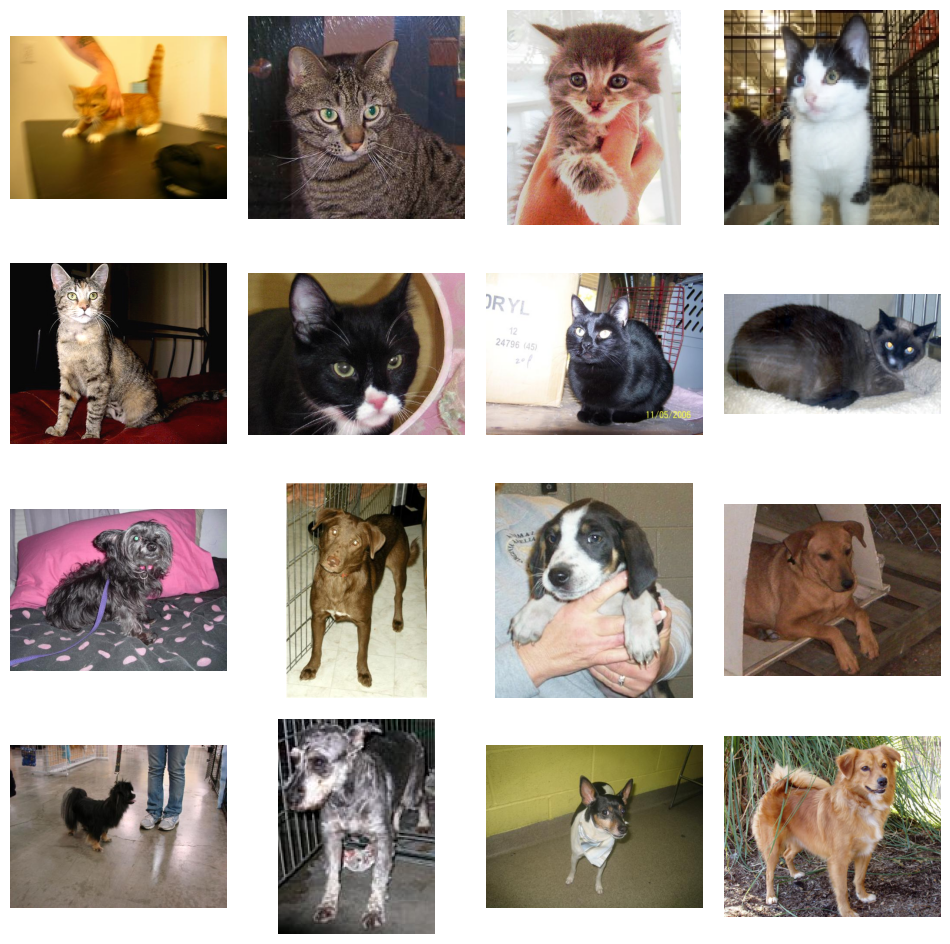

In [16]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [17]:
# Obliczenie rozmiarów zbiorów
size = len(os.listdir(os.path.join('dataset/train/Cat'))) + len(os.listdir(os.path.join('dataset/train/Dog')))
train_size = size
valid_size = len(os.listdir(os.path.join('dataset/valid/Cat'))) + len(os.listdir(os.path.join('dataset/valid/Dog')))

In [18]:
# Parametry modelu
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64

# Tworzenie generatorów danych
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Przygotowanie generatorów
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Ustawienie pozostałych parametrów
steps_per_epoch = 136  # Ustawiamy tyle samo co w książce
validation_steps = validation_generator.samples // batch_size

print(f'Parametry treningu:')
print(f'Steps per epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')
print(f'Batch size: {batch_size}')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Parametry treningu:
Steps per epoch: 136
Validation steps: 78
Batch size: 64
Found 4998 images belonging to 2 classes.
Parametry treningu:
Steps per epoch: 136
Validation steps: 78
Batch size: 64


In [19]:
# Sprawdzenie liczby obrazów w zbiorze treningowym
n_train_cats = len(os.listdir(os.path.join('dataset/train/Cat')))
n_train_dogs = len(os.listdir(os.path.join('dataset/train/Dog')))
total_train = n_train_cats + n_train_dogs

print(f'Liczba kotów w zbiorze treningowym: {n_train_cats}')
print(f'Liczba psów w zbiorze treningowym: {n_train_dogs}')
print(f'Całkowita liczba obrazów treningowych: {total_train}')

# Dostosowanie parametrów
batch_size = 364 # Zmniejszamy batch size
steps_per_epoch = total_train // batch_size

print(f'\nNowe parametry:')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

Liczba kotów w zbiorze treningowym: 8750
Liczba psów w zbiorze treningowym: 8750
Całkowita liczba obrazów treningowych: 17500

Nowe parametry:
Batch size: 364
Steps per epoch: 48


In [20]:
models = []
# Tworzenie folderów jeśli nie istnieją
if not os.path.exists('history'):
    os.mkdir('history')
if not os.path.exists('charts'):
    os.mkdir('charts')

Model podstawowy - Baseline

In [24]:


model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        67,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
patience = 10  
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [29]:
history_baseline = model_baseline.fit(train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps=validation_steps,
                                    callbacks=[es])

history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.5015 - loss: 1.2840 - val_accuracy: 0.5006 - val_loss: 0.9010
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.5015 - loss: 1.2840 - val_accuracy: 0.5006 - val_loss: 0.9010
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.4850 - loss: 1.0047 - val_accuracy: 0.5004 - val_loss: 0.8838
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.4850 - loss: 1.0047 - val_accuracy: 0.5004 - val_loss: 0.8838
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.5045 - loss: 0.9530 - val_accuracy: 0.5004 - val_loss: 1.0009
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.5045 - loss: 0.9530 - val_accuracy: 0.5004 - val_loss: 1.0009
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.5023 - loss: 0.9777 - val_accuracy: 0.5000 - val_loss: 1.3257
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.5023 - loss: 0

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.5072 - loss: 0.9365 - val_accuracy: 0.5635 - val_loss: 0.6922
Epoch 7/1000
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 529ms/step - accuracy: 0.4982 - loss: 0.9470 - val_accuracy: 0.5435 - val_loss: 0.7039
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 529ms/step - accuracy: 0.4982 - loss: 0.9470 - val_accuracy: 0.5435 - val_loss: 0.7039
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 487ms/step - accuracy: 0.4982 - loss: 0.9078 - val_accuracy: 0.5040 - val_loss: 0.9155
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 487ms/step - accuracy: 0.4982 - loss: 0.9078 - val_accuracy: 0.5040 - val_loss: 0.9155
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.5066 - loss: 0.9144 - val_accuracy: 0.5515 - val_loss: 0.6980
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.5066 - loss: 0.9144 - val_accuracy: 0.5515 - val_loss: 0.6980
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 480ms/step - accuracy: 0.5368 - loss:

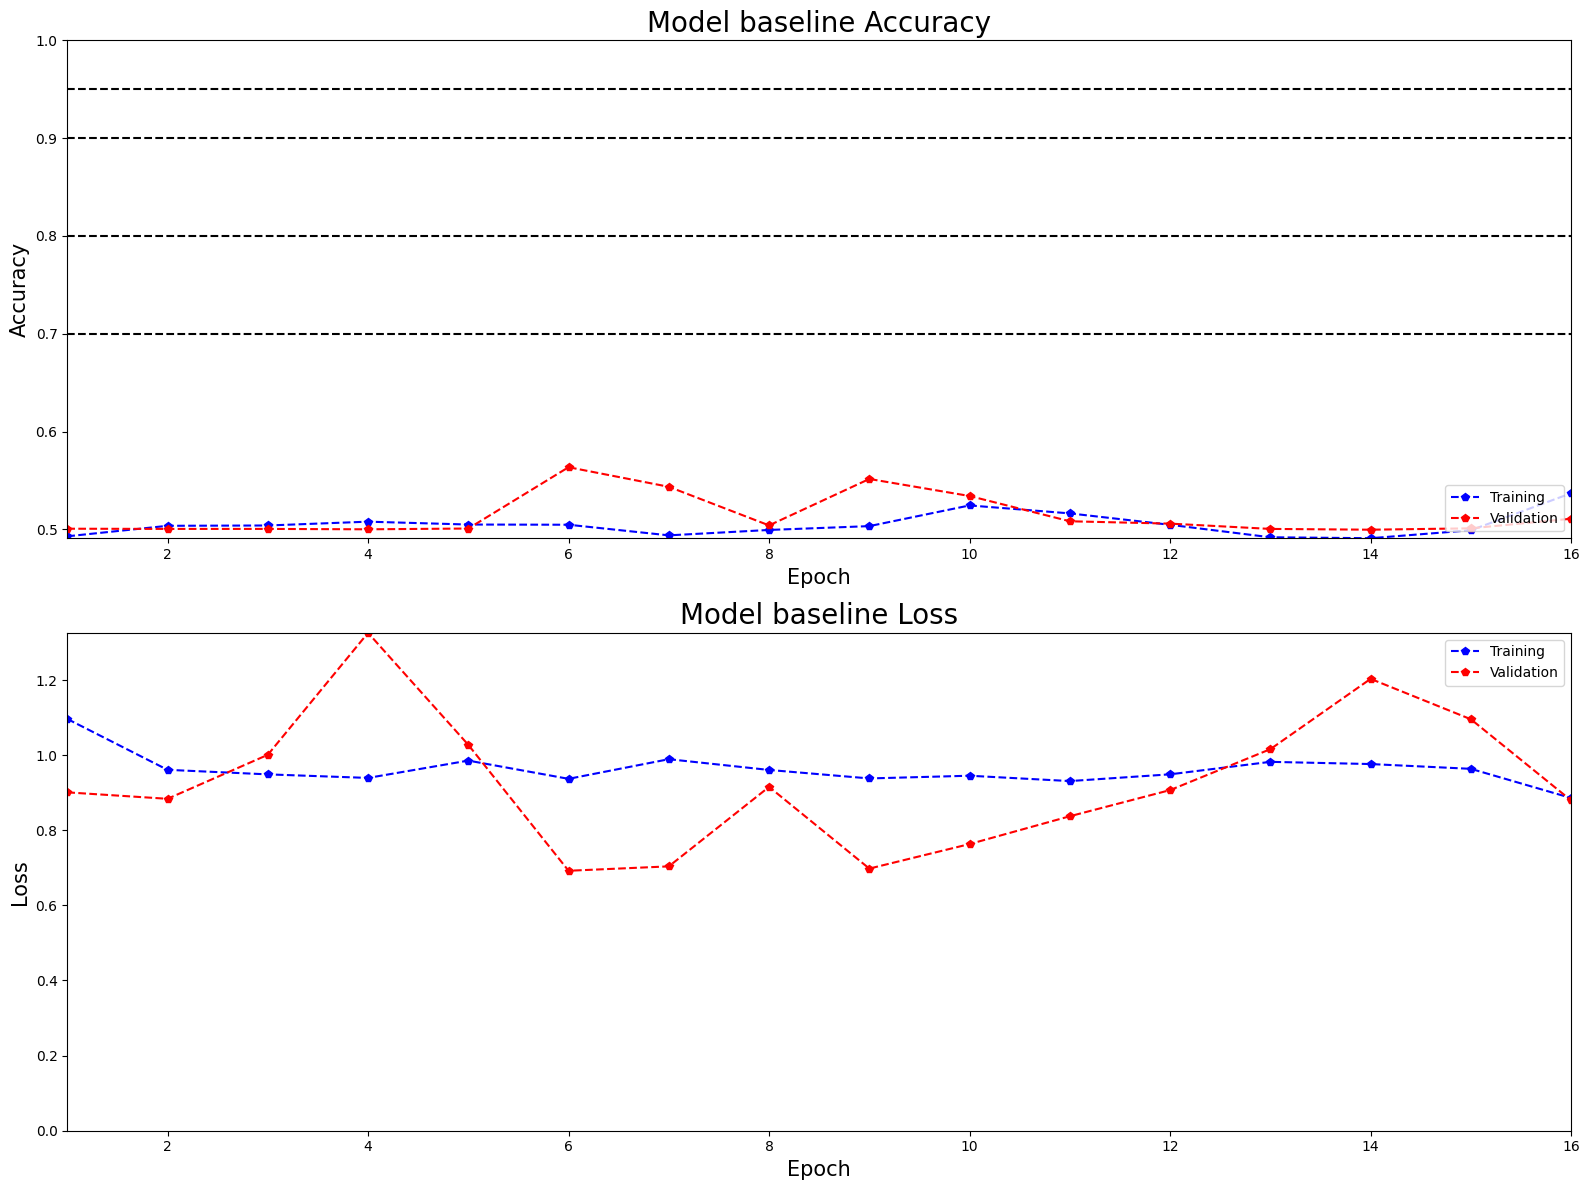

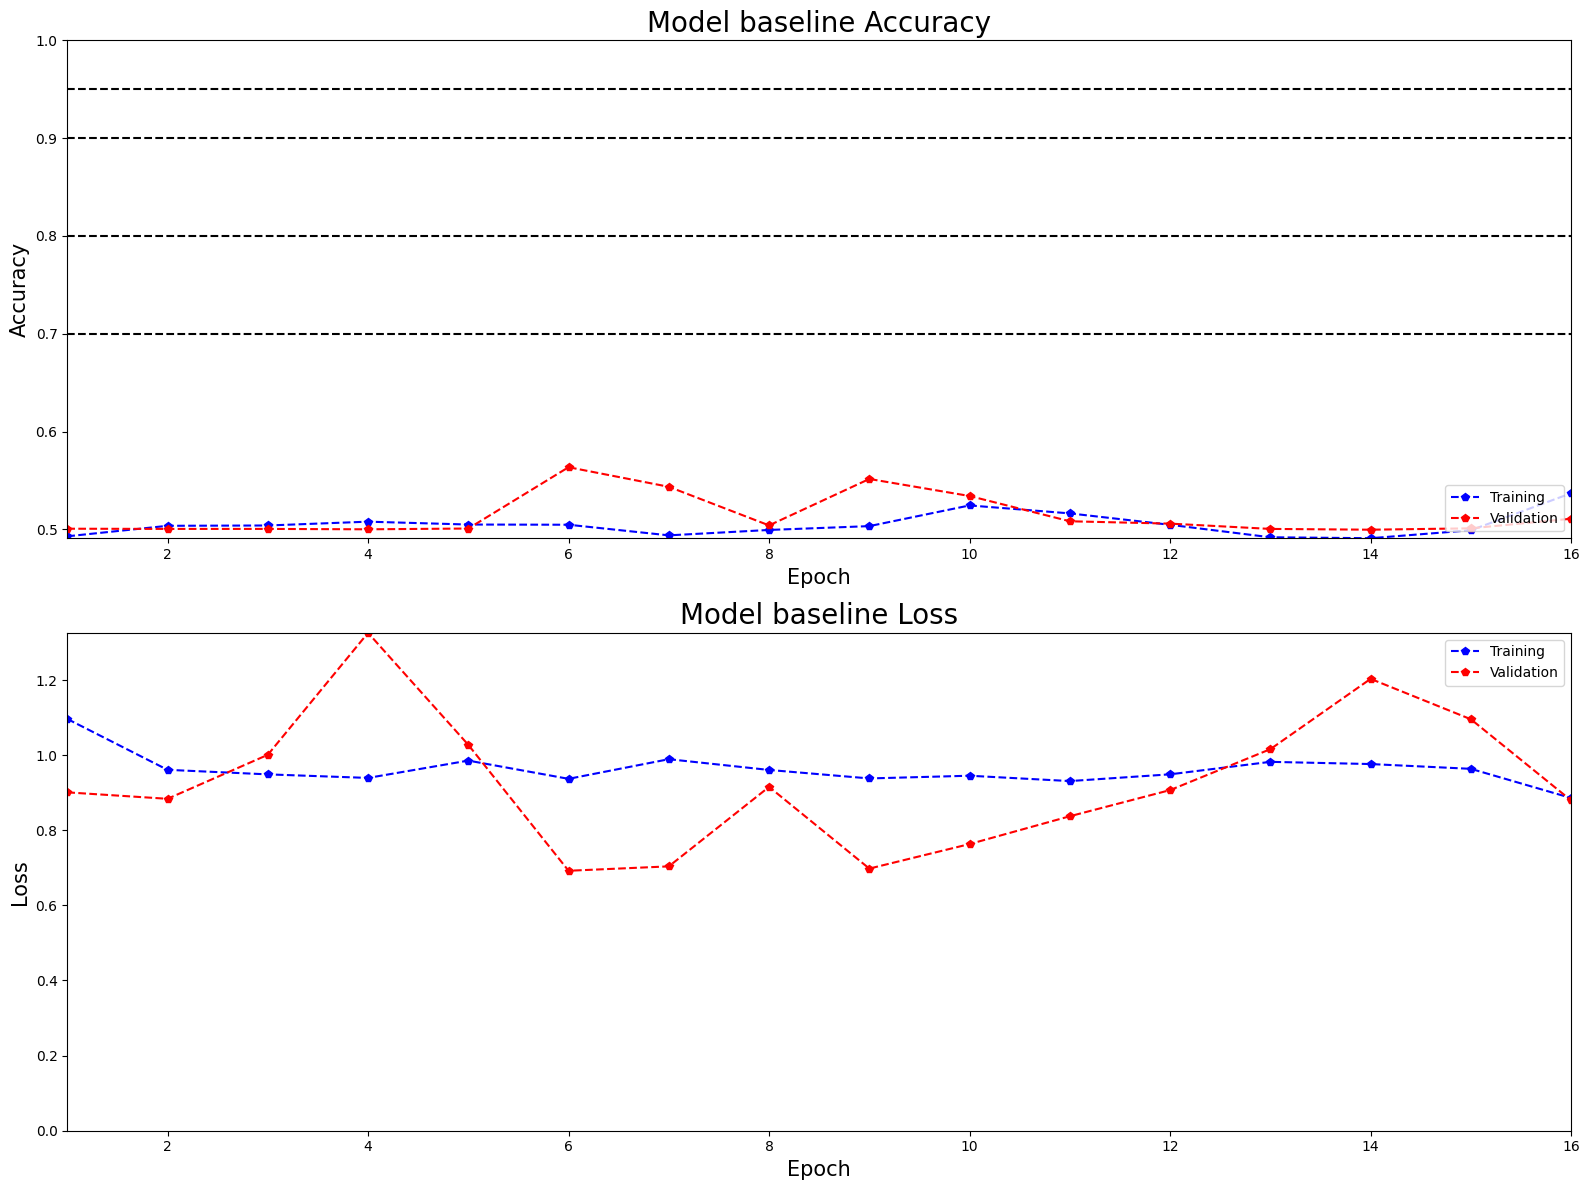

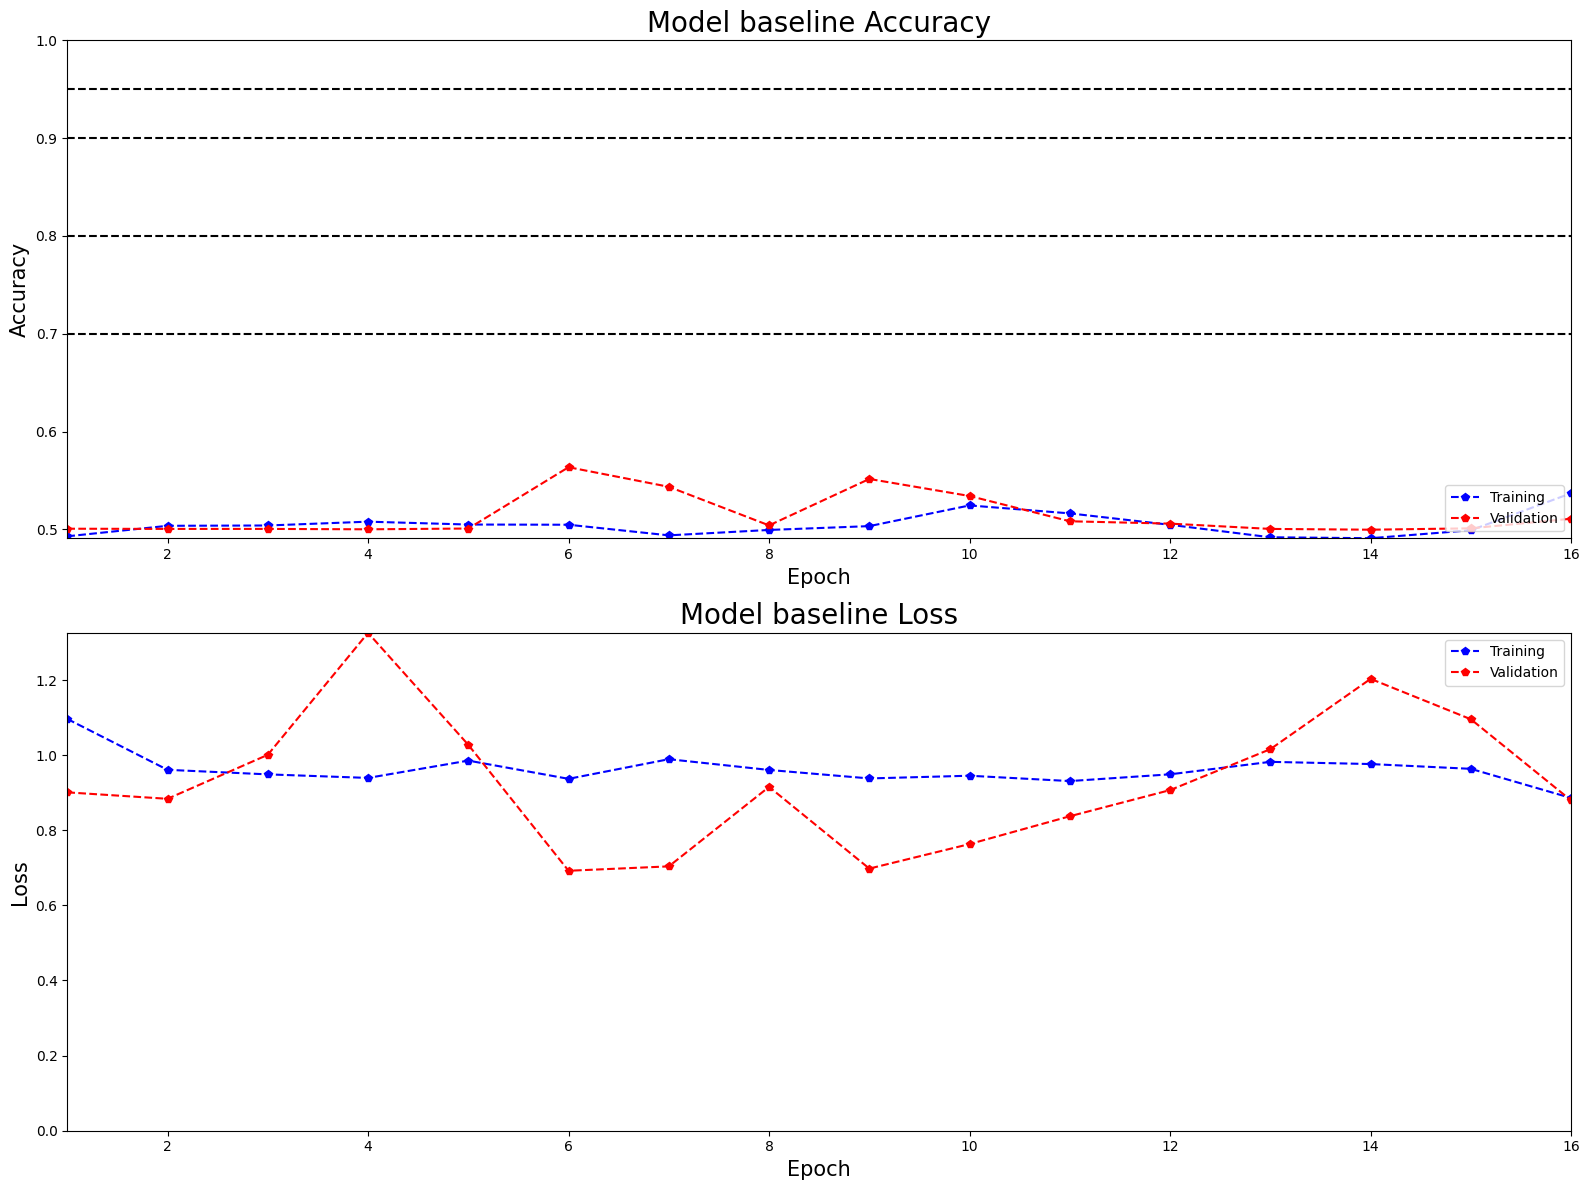

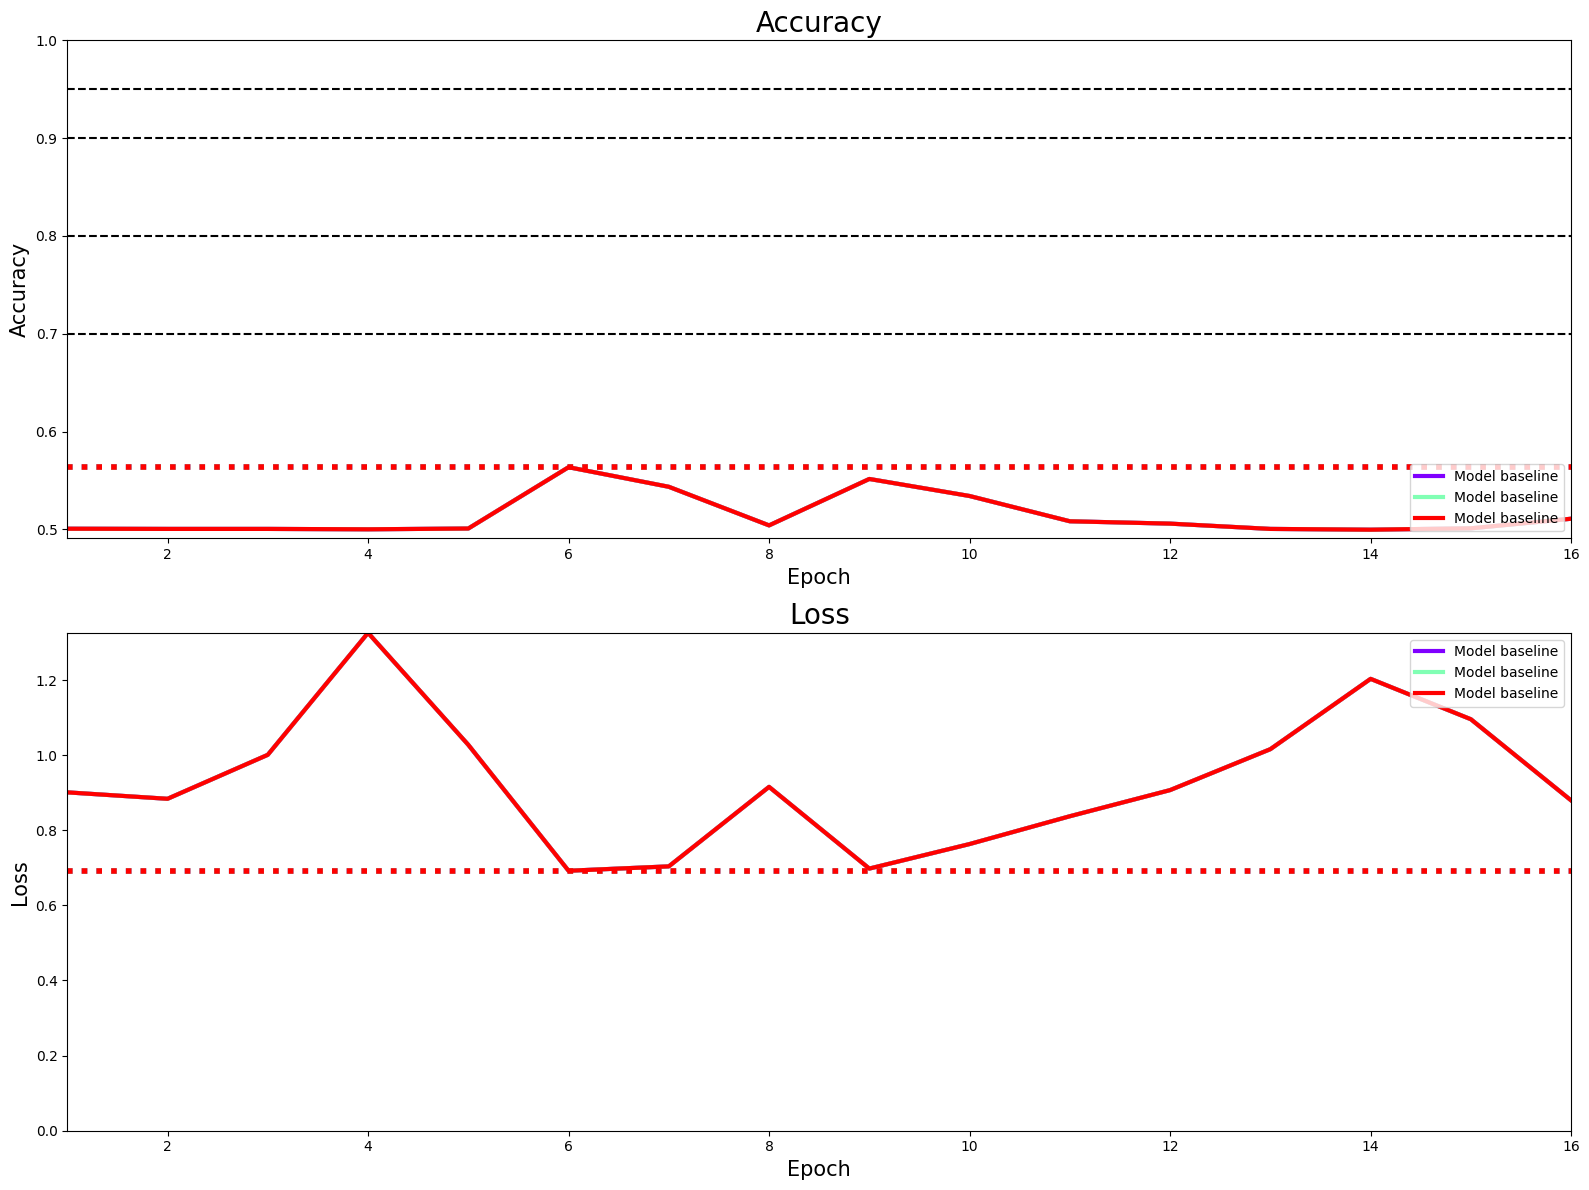

In [30]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

Model podstawowy 1


In [ ]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 54760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        54,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,041 (215.00 KB)

 Trainable params: 55,041 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.5104 - loss: 1.0910 - val_accuracy: 0.5911 - val_loss: 0.6659
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.5104 - loss: 1.0910 - val_accuracy: 0.5911 - val_loss: 0.6659
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 472ms/step - accuracy: 0.5684 - loss: 0.6735 - val_accuracy: 0.6102 - val_loss: 0.6445
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 472ms/step - accuracy: 0.5684 - loss: 0.6735 - val_accuracy: 0.6102 - val_loss: 0.6445
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 527ms/step - accuracy: 0.5923 - loss: 0.6634 - val_accuracy: 0.6000 - val_loss: 0.6491
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 527ms/step - accuracy: 0.5923 - loss: 0.6634 - val_accuracy: 0.6000 - val_loss: 0.6491
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.6226 - loss: 0.6440 - val_accuracy: 0.6092 - val_loss: 0.6519
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.6226 - loss: 0

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - accuracy: 0.6148 - loss: 0.6537 - val_accuracy: 0.5823 - val_loss: 0.6725
Epoch 7/1000
Epoch 7/1000
27/48 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.6000 - loss: 0.6412

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6071 - loss: 0.6405 - val_accuracy: 0.6603 - val_loss: 0.6144
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step - accuracy: 0.6071 - loss: 0.6405 - val_accuracy: 0.6603 - val_loss: 0.6144
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6182 - loss: 0.6425 - val_accuracy: 0.6374 - val_loss: 0.6335
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 644ms/step - accuracy: 0.6182 - loss: 0.6425 - val_accuracy: 0.6374 - val_loss: 0.6335
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 513ms/step - accuracy: 0.6416 - loss: 0.6317 - val_accuracy: 0.6158 - val_loss: 0.6608
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 513ms/step - accuracy: 0.6416 - loss: 0.6317 - val_accuracy: 0.6158 - val_loss: 0.6608
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 523ms/step - accuracy: 0.6331 - loss: 0.6435 - val_accuracy: 0.6593 - val_loss: 0.6078
Epoch 11/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 523ms/step - accuracy: 0.6331 - loss: 0.6435 - va

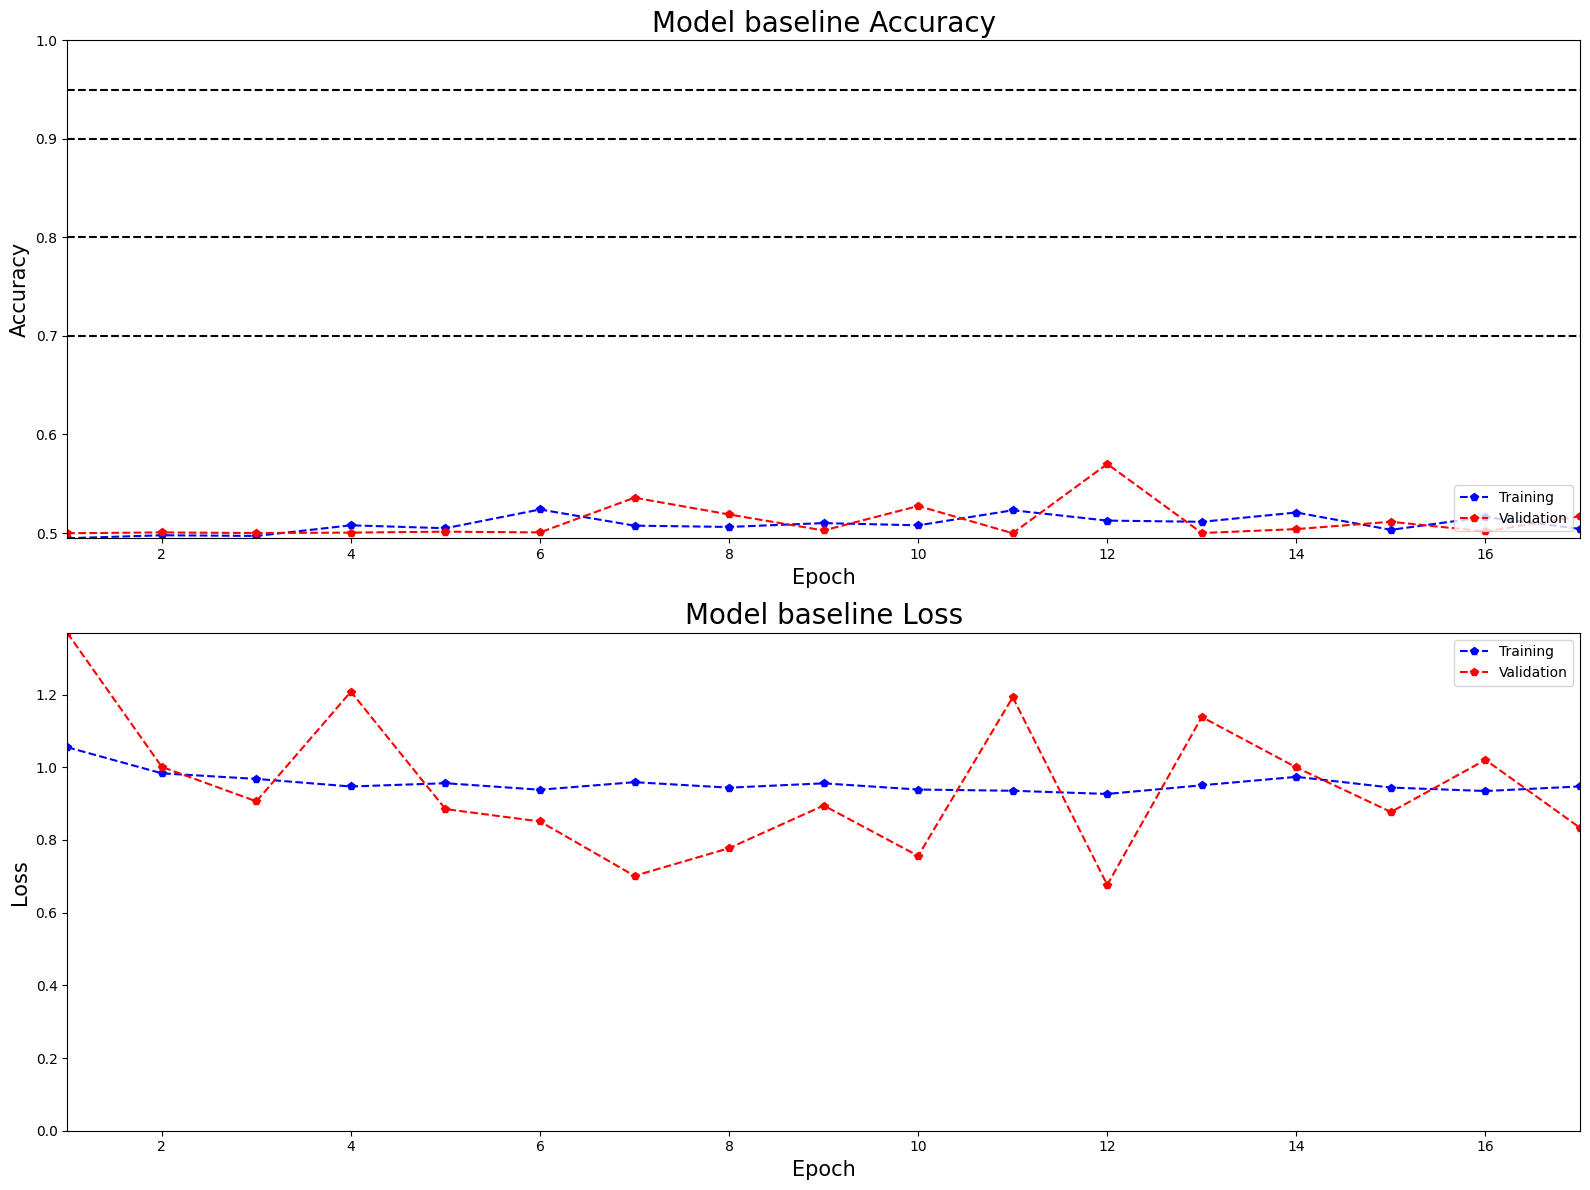

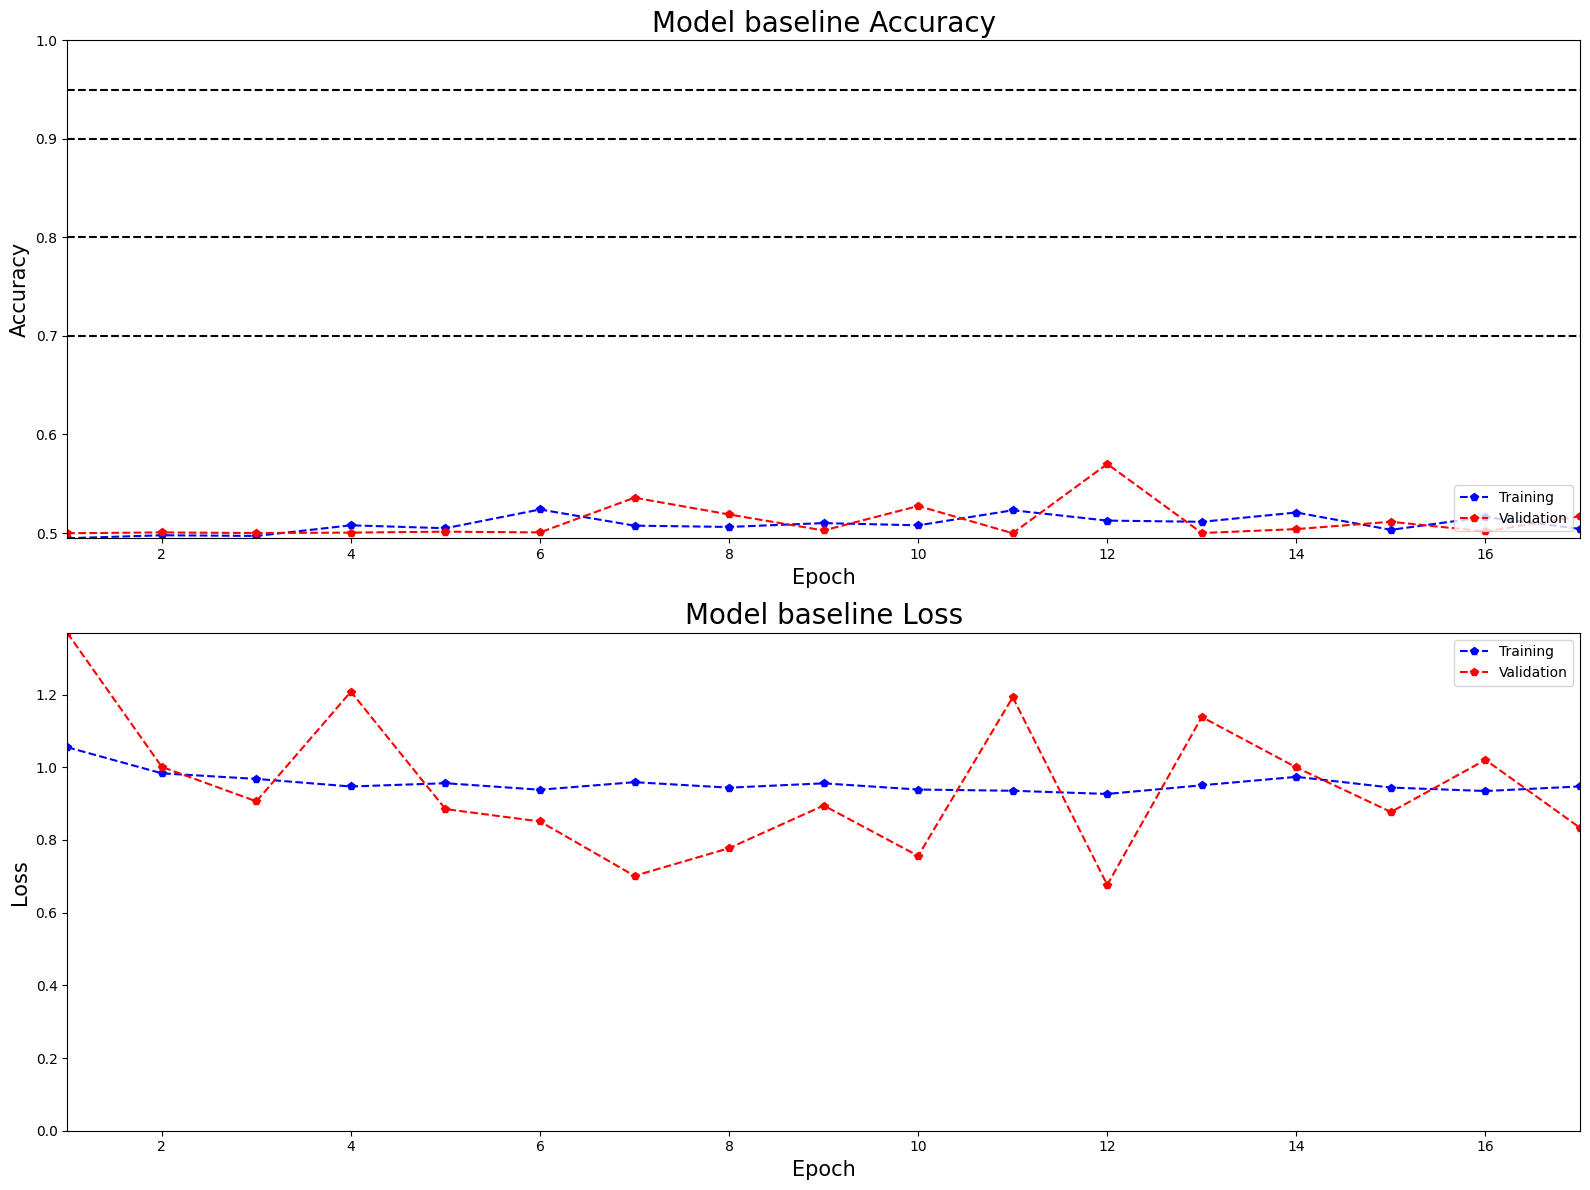

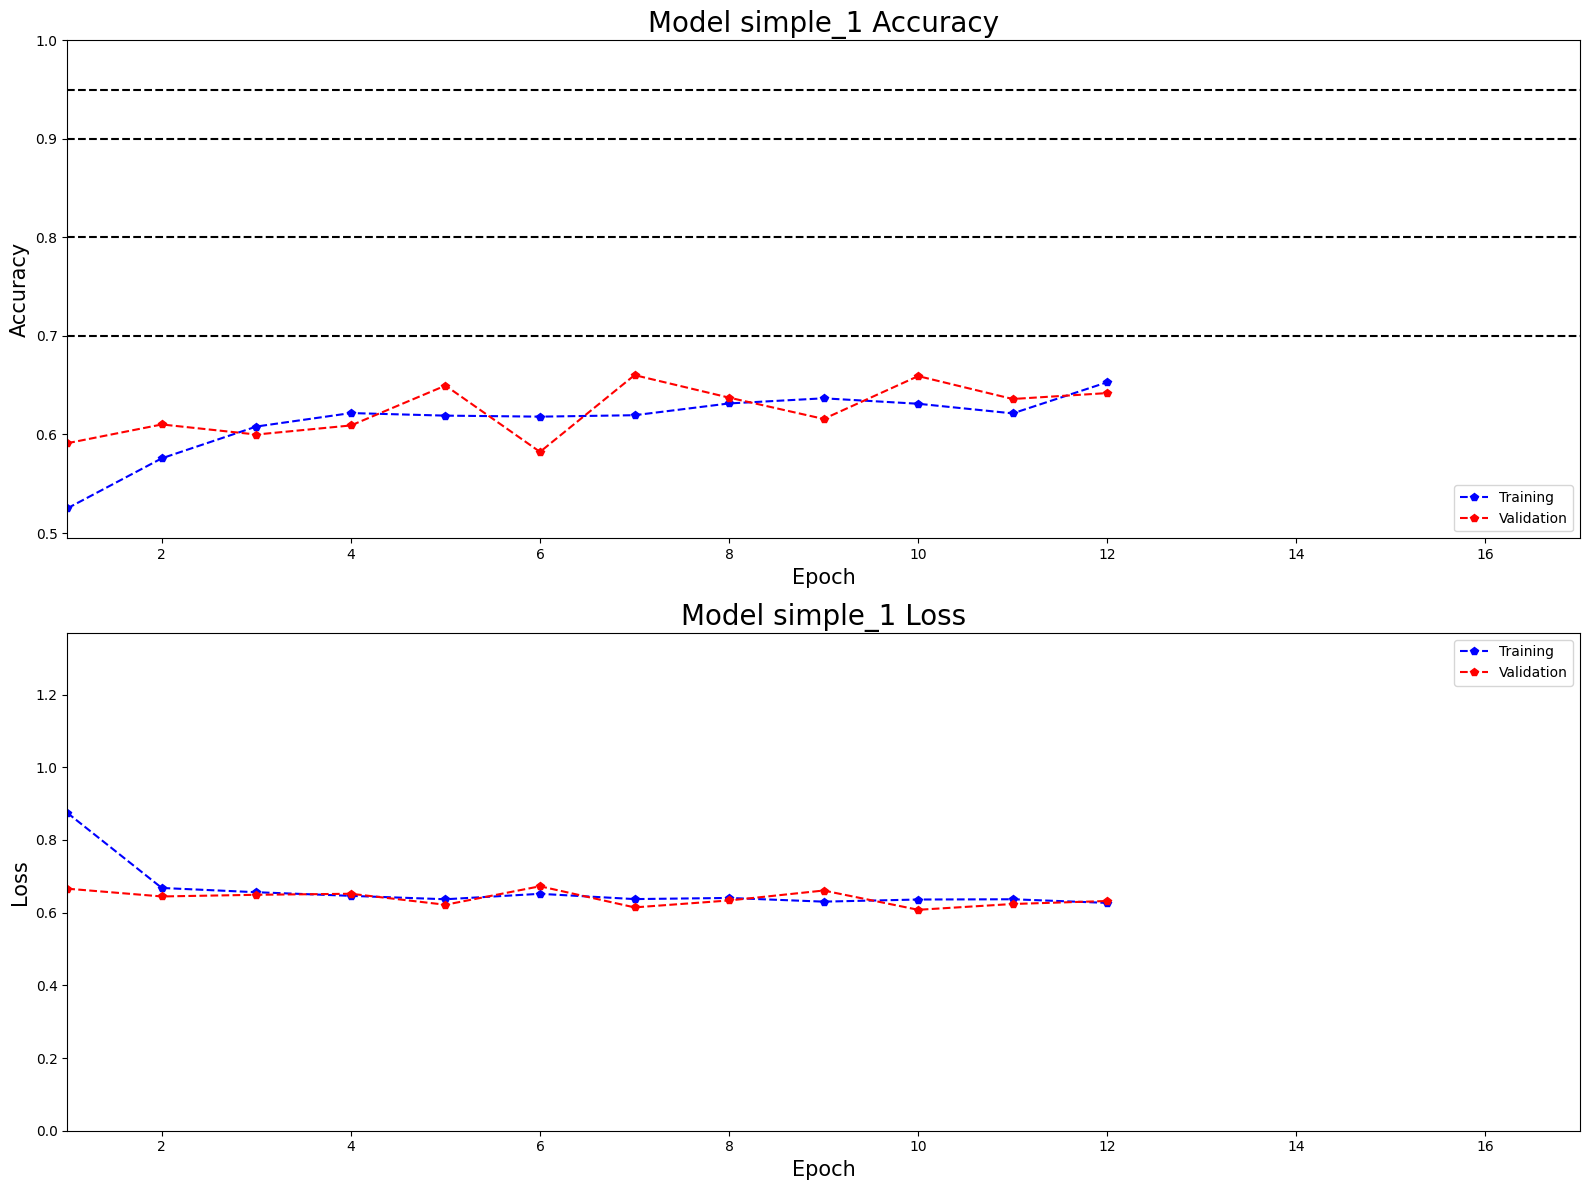

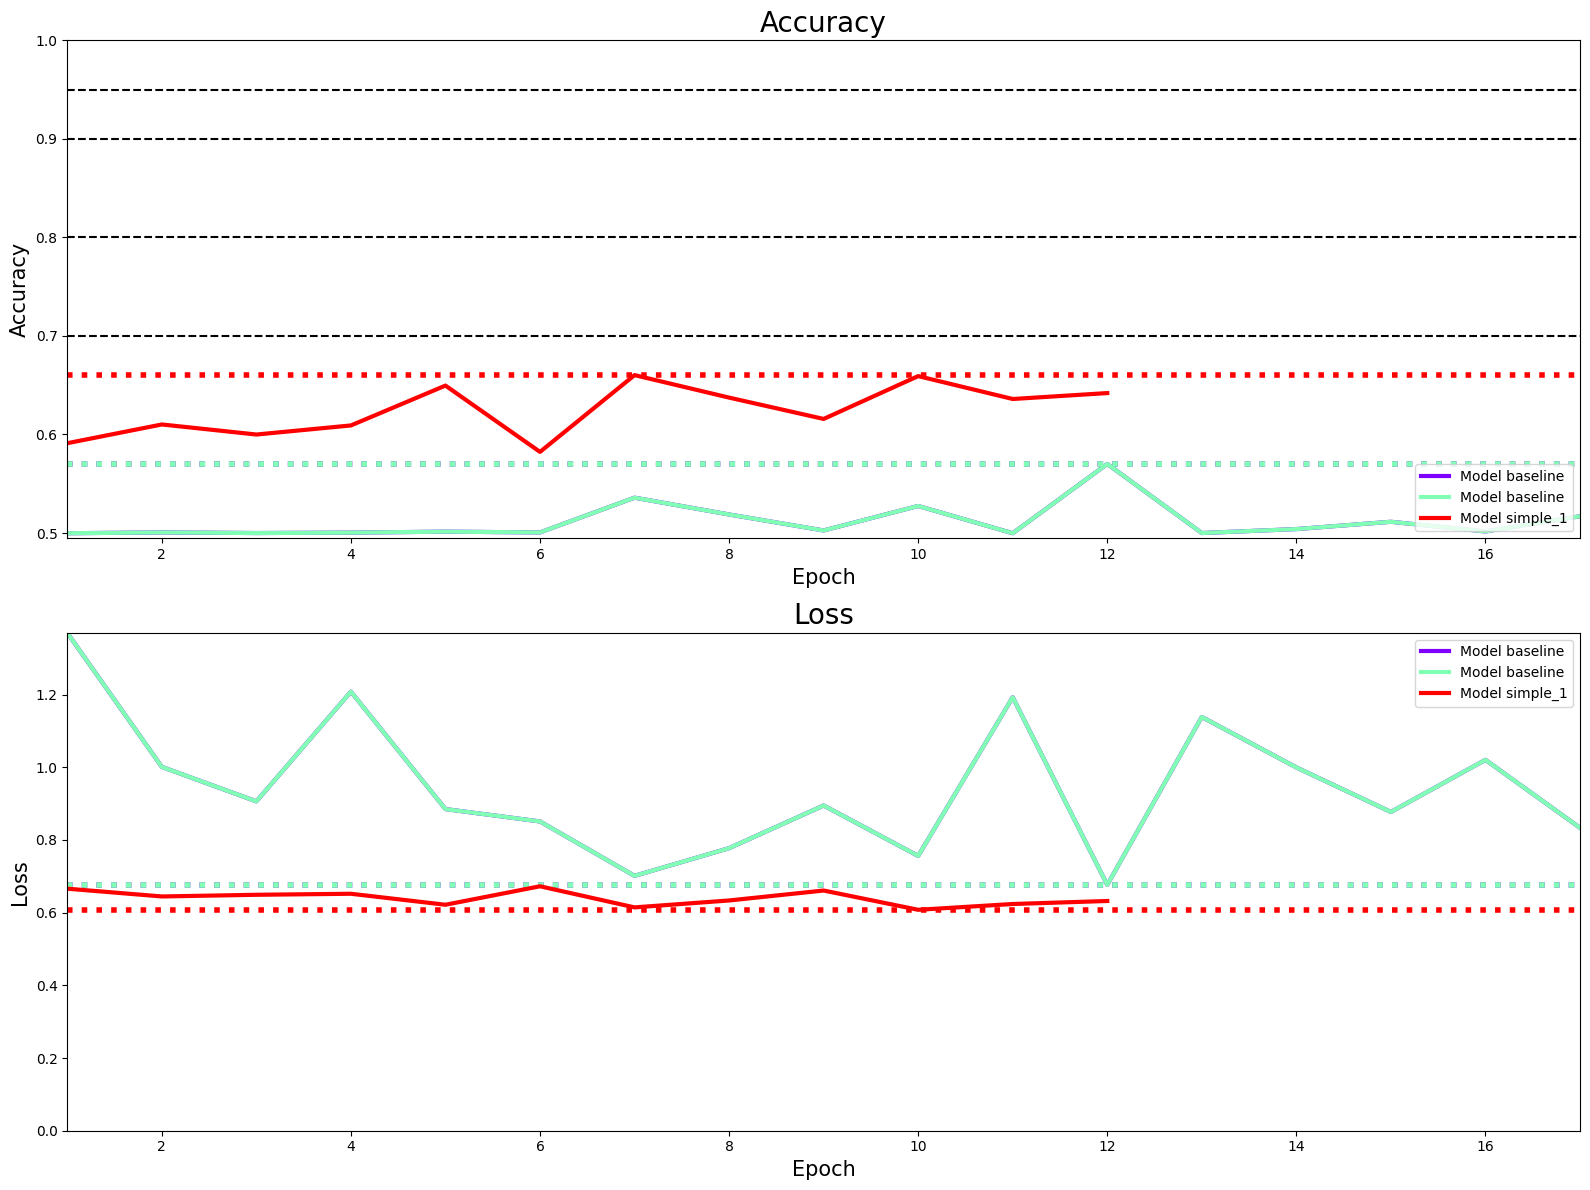

In [ ]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

Model podstawowy 2

In [ ]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 56250)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        56,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,531 (220.82 KB)

 Trainable params: 56,531 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 523ms/step - accuracy: 0.5015 - loss: 1.6783 - val_accuracy: 0.5585 - val_loss: 0.6781
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 523ms/step - accuracy: 0.5015 - loss: 1.6783 - val_accuracy: 0.5585 - val_loss: 0.6781
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - accuracy: 0.5345 - loss: 0.6927 - val_accuracy: 0.6272 - val_loss: 0.6506
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - accuracy: 0.5345 - loss: 0.6927 - val_accuracy: 0.6272 - val_loss: 0.6506
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - accuracy: 0.6000 - loss: 0.6582 - val_accuracy: 0.6168 - val_loss: 0.6506
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - accuracy: 0.6000 - loss: 0.6582 - val_accuracy: 0.6168 - val_loss: 0.6506
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 578ms/step - accuracy: 0.6231 - loss: 0.6508 - val_accuracy: 0.6136 - val_loss: 0.6680
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 578ms/step - accuracy: 0.6231 - loss: 0

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.6144 - loss: 0.6585 - val_accuracy: 0.6020 - val_loss: 0.6657
Epoch 7/1000
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step - accuracy: 0.6447 - loss: 0.6433 - val_accuracy: 0.6583 - val_loss: 0.6234
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step - accuracy: 0.6447 - loss: 0.6433 - val_accuracy: 0.6583 - val_loss: 0.6234
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6356 - loss: 0.6261 - val_accuracy: 0.6665 - val_loss: 0.6257
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.6356 - loss: 0.6261 - val_accuracy: 0.6665 - val_loss: 0.6257
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - accuracy: 0.6364 - loss: 0.6384 - val_accuracy: 0.6482 - val_loss: 0.6419
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - accuracy: 0.6364 - loss: 0.6384 - val_accuracy: 0.6482 - val_loss: 0.6419
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 548ms/step - accuracy: 0.6290 - loss:

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.6452 - loss: 0.6419 - val_accuracy: 0.6659 - val_loss: 0.6260
Epoch 14/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.6452 - loss: 0.6419 - val_accuracy: 0.6659 - val_loss: 0.6260
Epoch 14/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 545ms/step - accuracy: 0.6380 - loss: 0.6439 - val_accuracy: 0.6372 - val_loss: 0.6317
Epoch 15/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 545ms/step - accuracy: 0.6380 - loss: 0.6439 - val_accuracy: 0.6372 - val_loss: 0.6317
Epoch 15/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.6547 - loss: 0.6199 - val_accuracy: 0.6332 - val_loss: 0.6278
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.6547 - loss: 0.6199 - val_accuracy: 0.6332 - val_loss: 0.6278


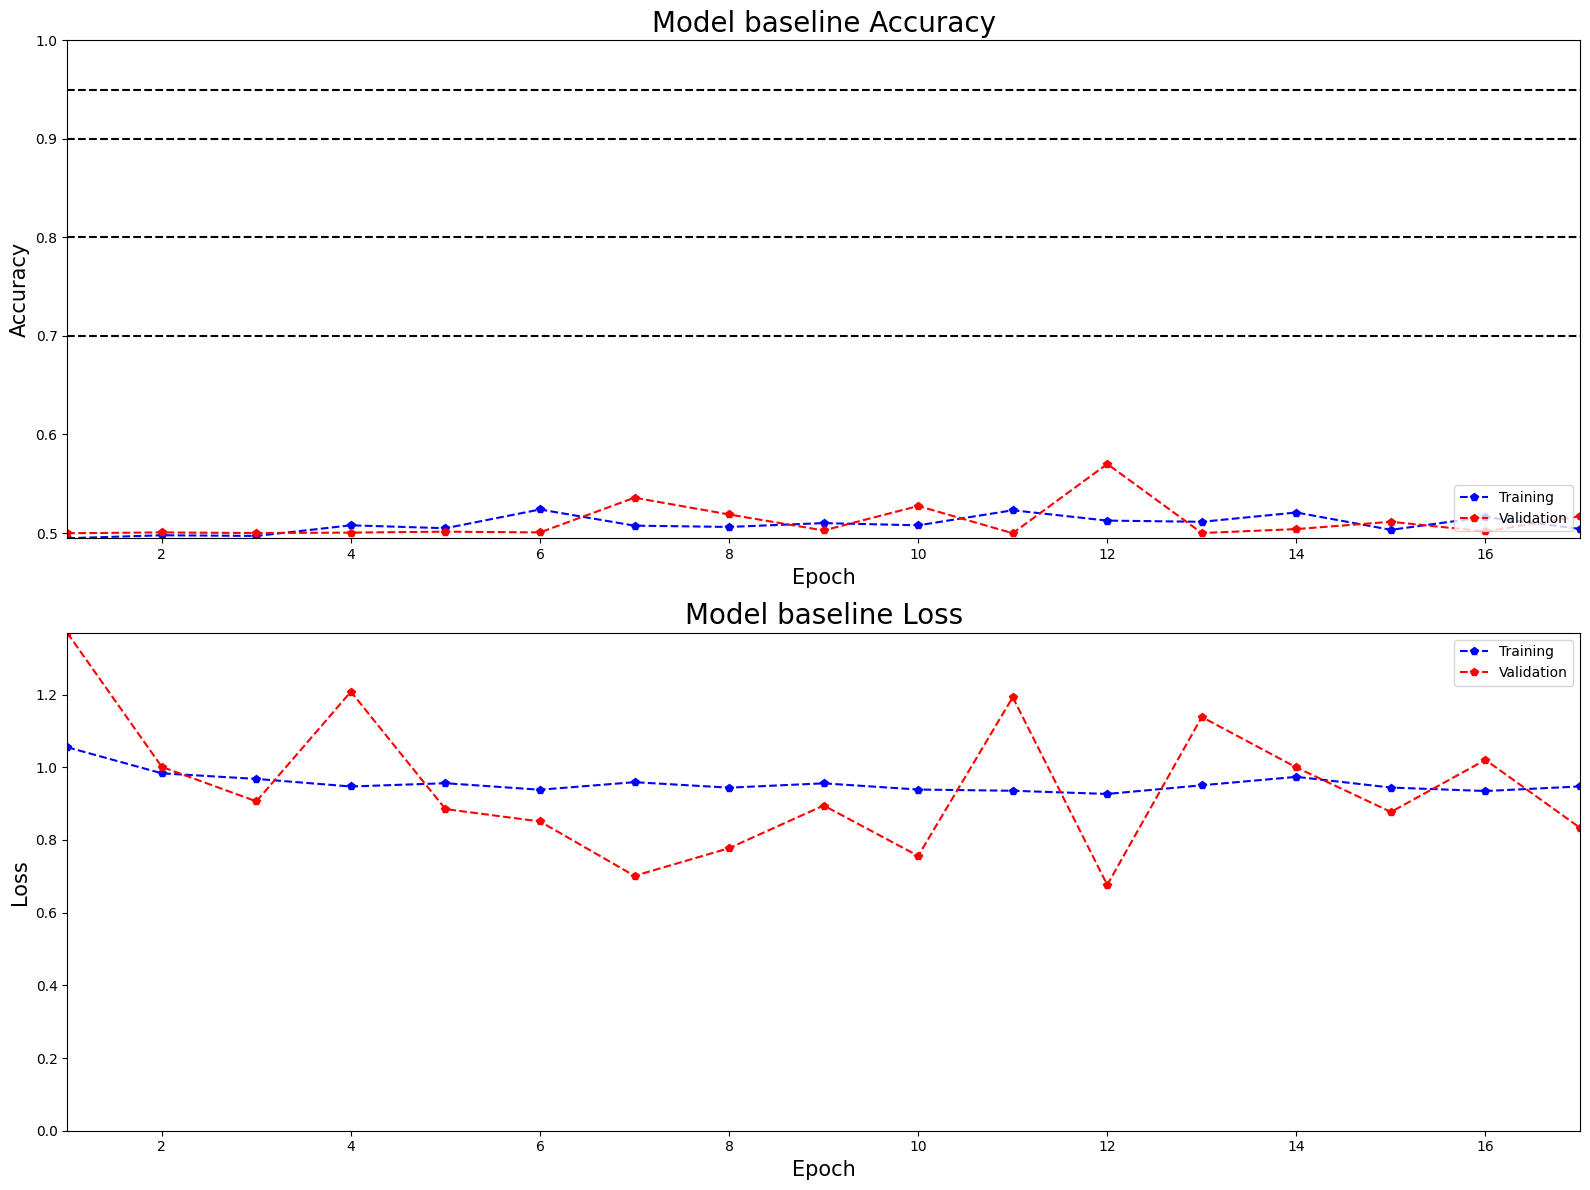

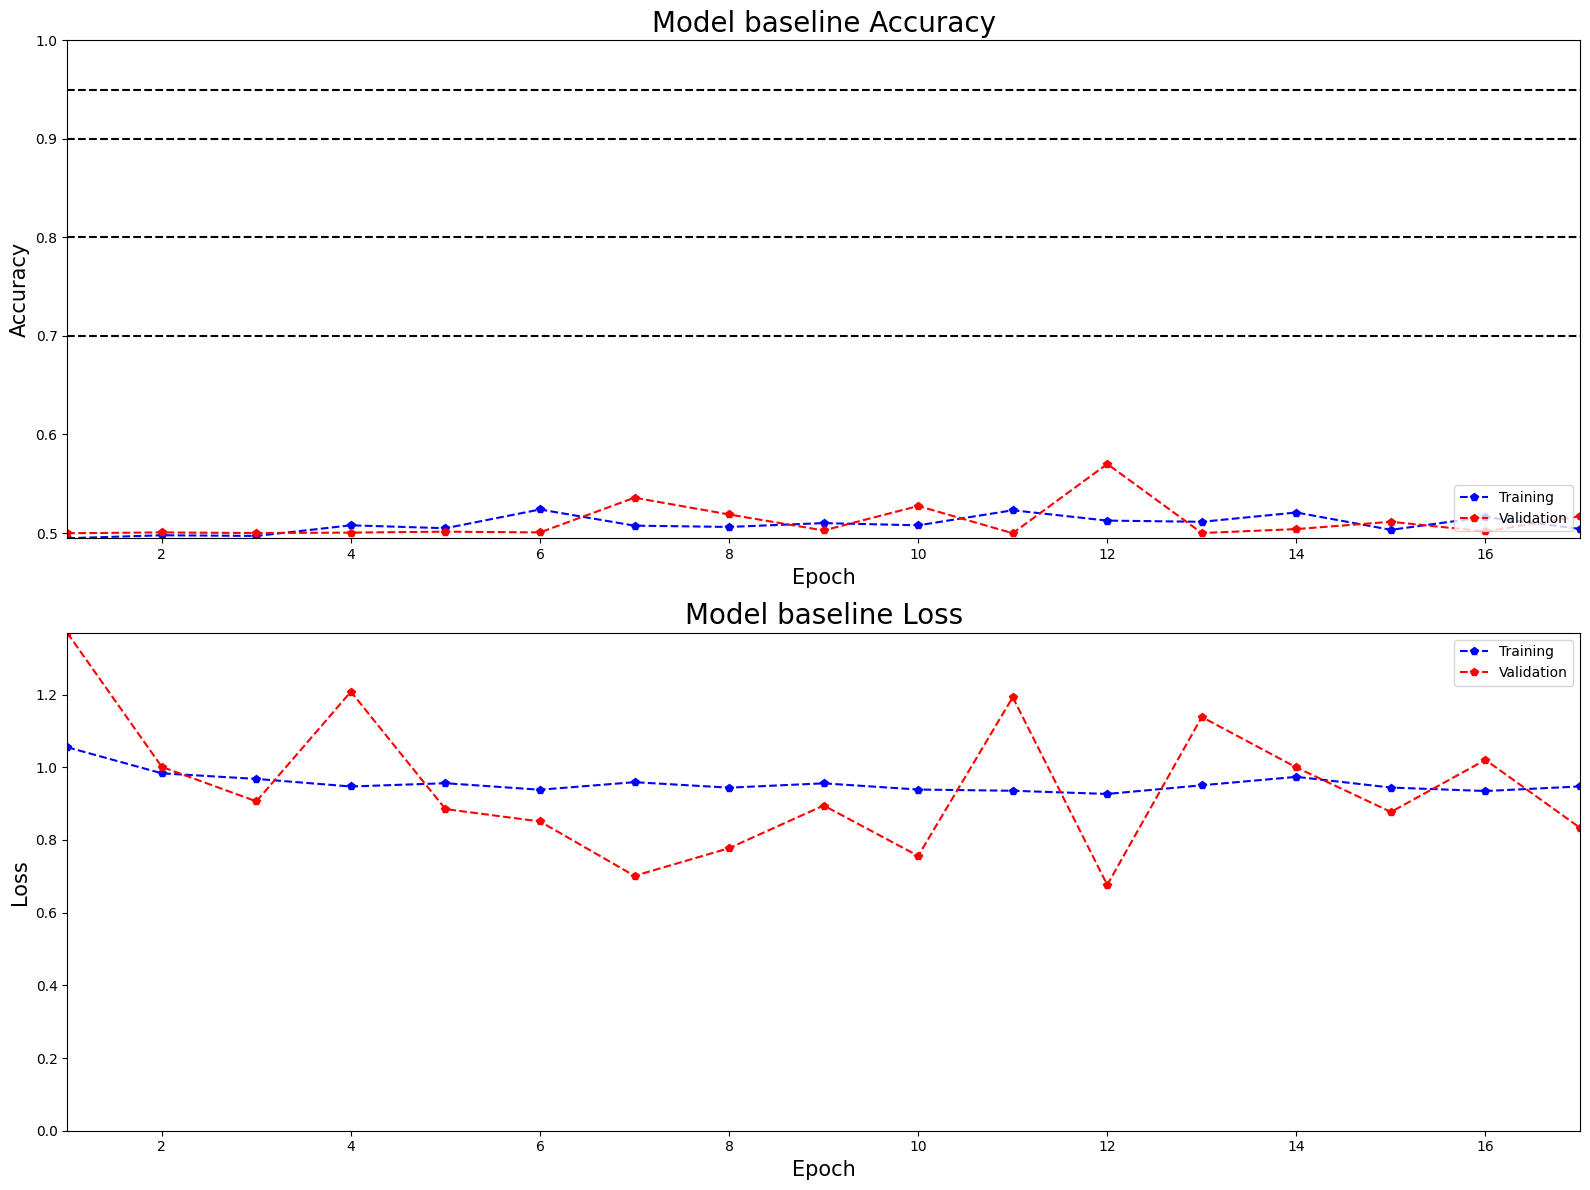

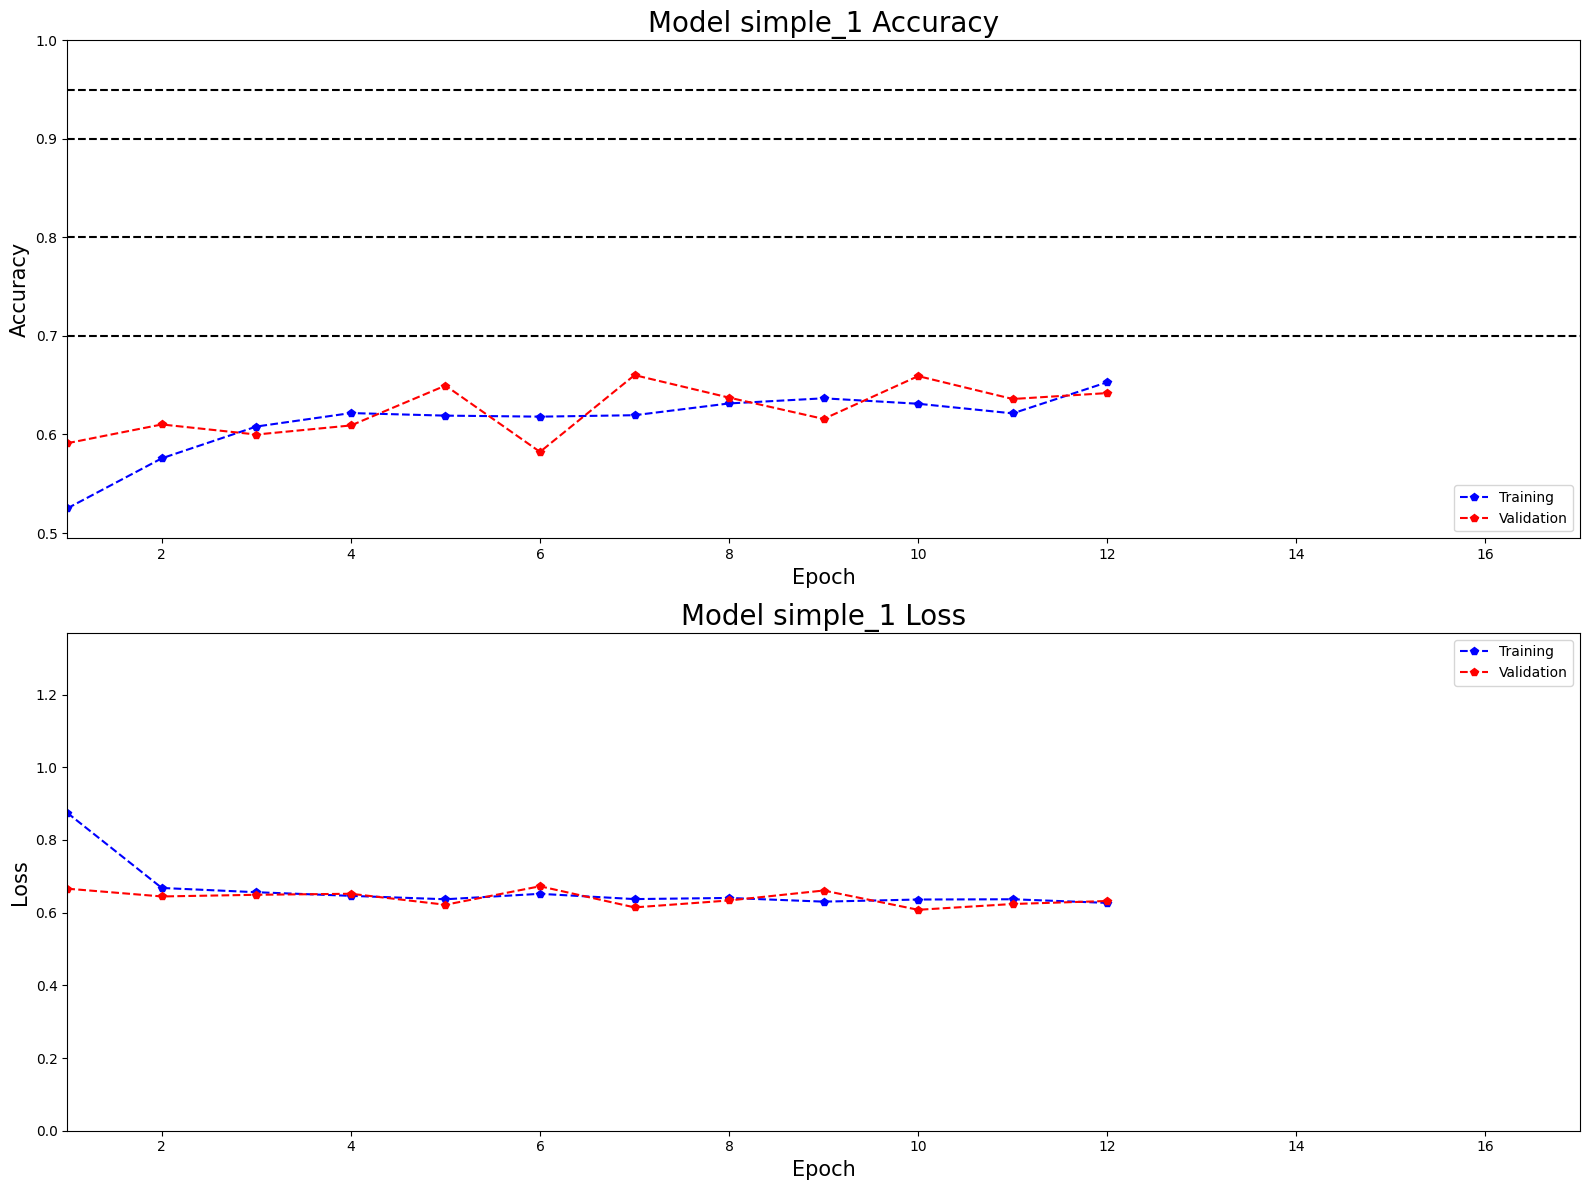

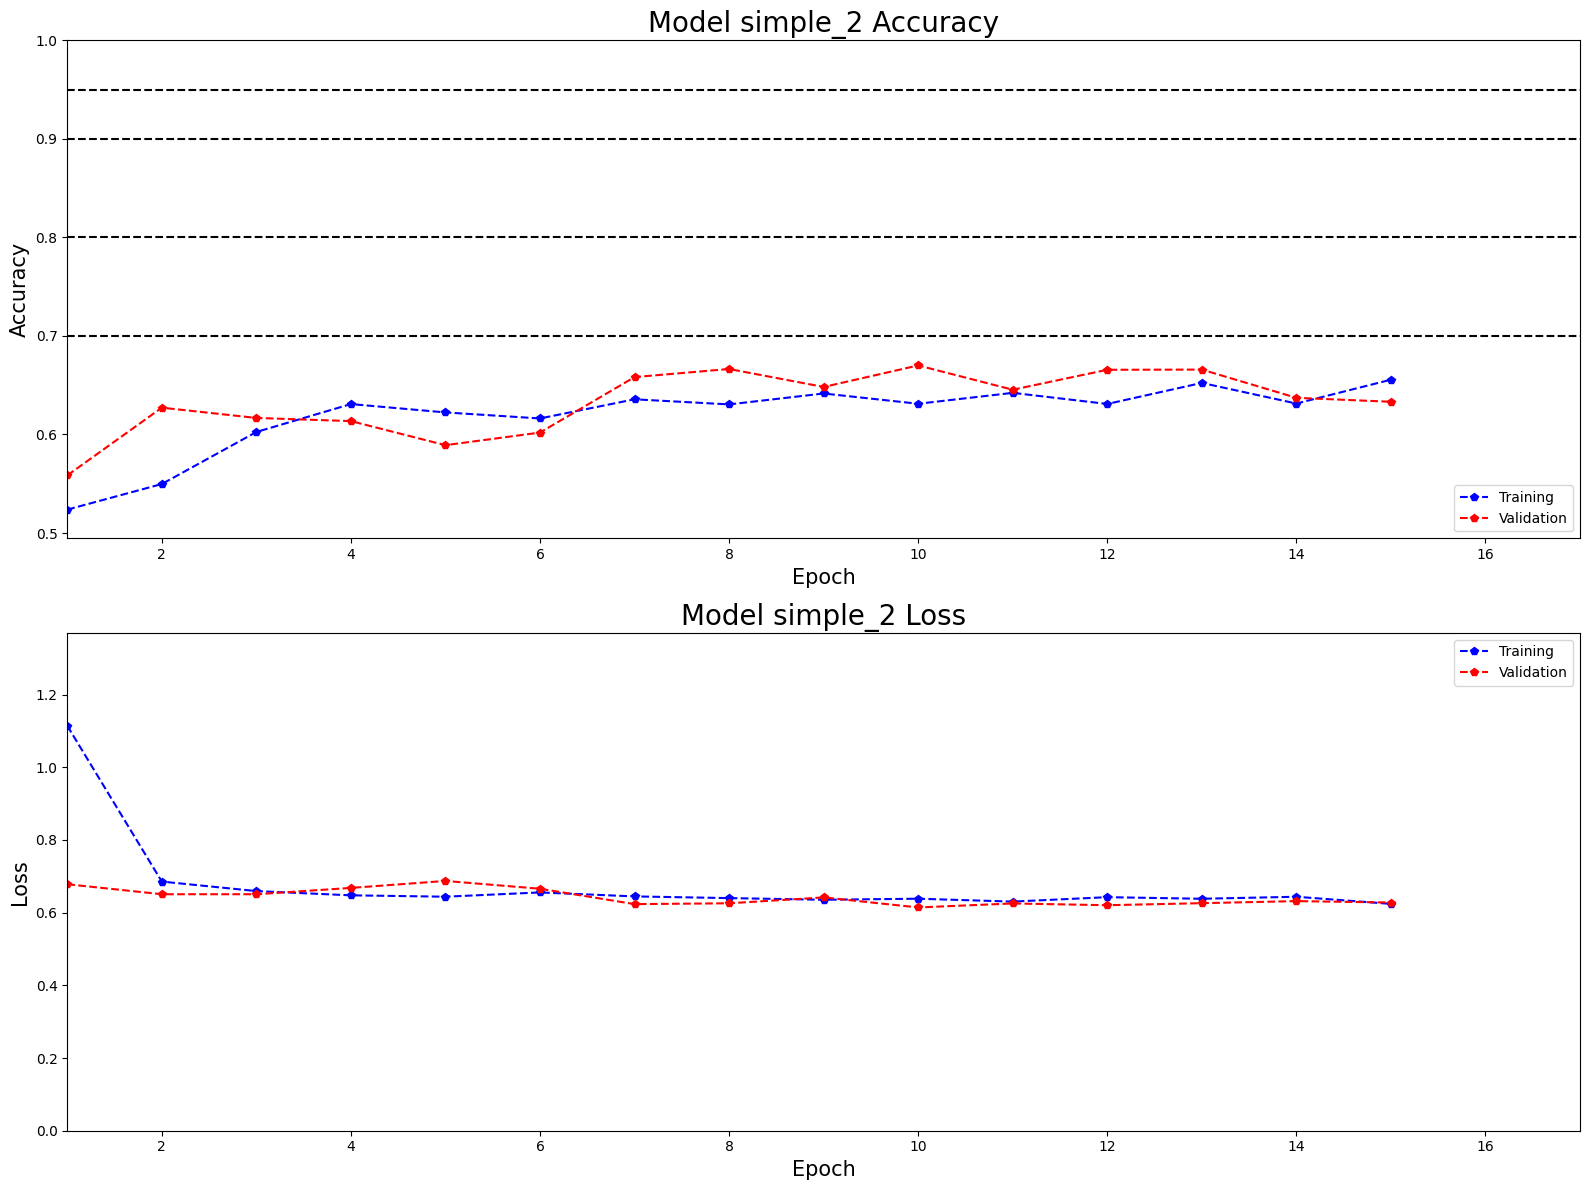

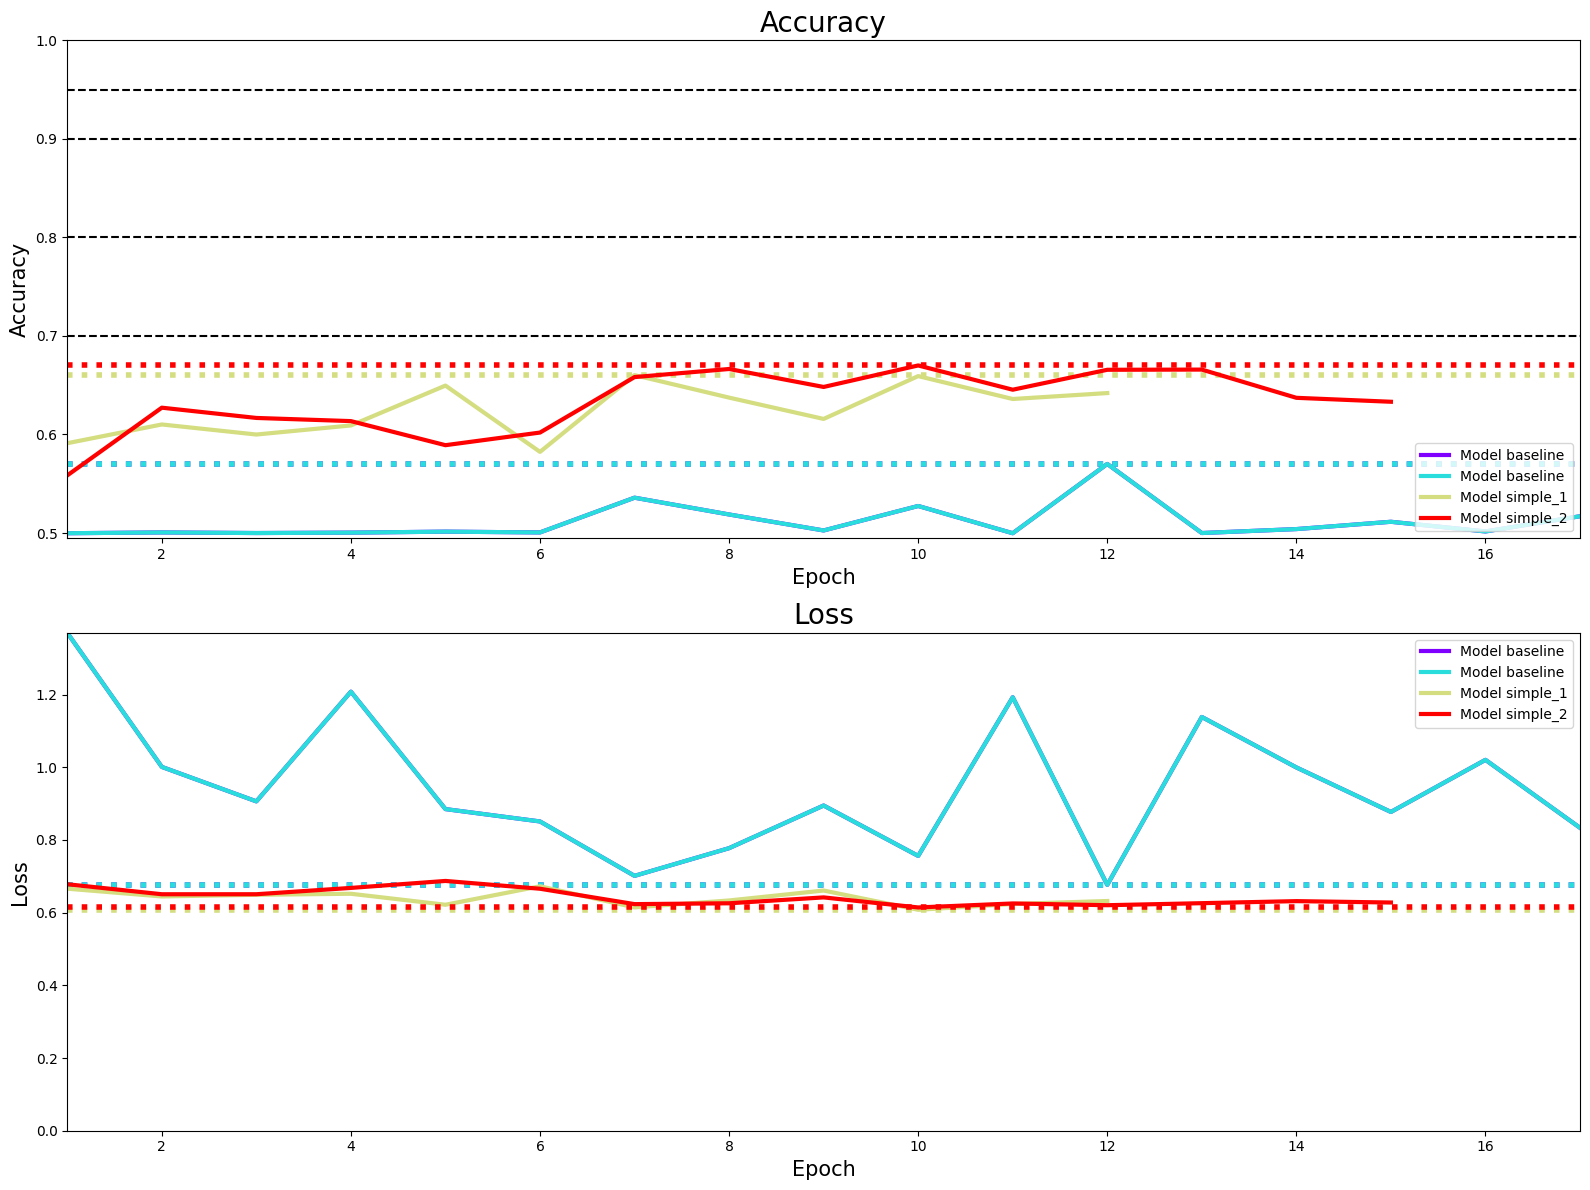

In [ ]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

Model CNN z wieloma blokami konwolucyjnymi

In [ ]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model_1.summary()
models.append("model_1")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_model_1 = model_1.fit(train_generator,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           validation_data=validation_generator,
                           validation_steps=validation_steps,
                           callbacks=[es])

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4922 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4922 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5197 - loss: 0.6918 - val_accuracy: 0.5012 - val_loss: 0.6896
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5197 - loss: 0.6918 - val_accuracy: 0.5012 - val_loss: 0.6896
Epoch 3/1000
24/48 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5388 - loss: 0.6906

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5398 - loss: 0.6901 - val_accuracy: 0.5006 - val_loss: 0.6887
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5398 - loss: 0.6901 - val_accuracy: 0.5006 - val_loss: 0.6887
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5623 - loss: 0.6861 - val_accuracy: 0.5823 - val_loss: 0.6724
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5623 - loss: 0.6861 - val_accuracy: 0.5823 - val_loss: 0.6724
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5736 - loss: 0.6789 - val_accuracy: 0.5865 - val_loss: 0.6645
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5736 - loss: 0.6789 - val_accuracy: 0.5865 - val_loss: 0.6645
Epoch 6/1000
34/48 ━━━━━━━━━━━━━━━━━━━━ 11s 786ms/step - accuracy: 0.5907 - loss: 0.6733

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5882 - loss: 0.6738 - val_accuracy: 0.5411 - val_loss: 0.6823
Epoch 7/1000
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6000 - loss: 0.6688 - val_accuracy: 0.6072 - val_loss: 0.6534
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6000 - loss: 0.6688 - val_accuracy: 0.6072 - val_loss: 0.6534
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5767 - loss: 0.6710 - val_accuracy: 0.6178 - val_loss: 0.6482
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5767 - loss: 0.6710 - val_accuracy: 0.6178 - val_loss: 0.6482
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5758 - loss: 0.6712 - val_accuracy: 0.5735 - val_loss: 0.6693
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5758 - loss: 0.6712 - val_accuracy: 0.5735 - val_loss: 0.6693
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5978 - loss: 0.6576 - val_accuracy: 

In [ ]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model_2.summary()
models.append("model_2")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_model_2 = model_2.fit(train_generator,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           validation_data=validation_generator,
                           validation_steps=validation_steps,
                           callbacks=[es])

history_model_2_df = pd.DataFrame(history_model_2.history)
history_model_2_csv_file = 'history/history_model_2.csv'

with open(history_model_2_csv_file, mode='w') as f:
    history_model_2_df.to_csv(f)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 973ms/step - accuracy: 0.5103 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 973ms/step - accuracy: 0.5103 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5076 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5076 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5006 - loss: 0.6929 - val_accuracy: 0.5008 - val_loss: 0.6887
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5006 - loss: 0.6929 - val_accuracy: 0.5008 - val_loss: 0.6887
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5160 - loss: 0.6891 - val_accuracy: 0.5002 - val_loss: 0.6917
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5160 - loss: 0.6891 - val_accura

In [80]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
model_3.summary()
models.append("model_3")



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history_model_3 = model_3.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5081 - loss: 0.6933 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5081 - loss: 0.6933 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4919 - loss: 0.6931 - val_accuracy: 0.5198 - val_loss: 0.6914
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4919 - loss: 0.6931 - val_accuracy: 0.5198 - val_loss: 0.6914
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4890 - loss: 0.6947 - val_accuracy: 0.5012 - val_loss: 0.6909
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4890 - loss: 0.6947 - val_accuracy: 0.5012 - val_loss: 0.6909
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.5060 - val_loss: 0.6904
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.

In [34]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
model_4.summary()
models.append("model_4")


train_datagen_aug_vgg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator_aug_vgg = train_datagen_aug_vgg.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


epochs_4 = 10  
batch_size_4 = 16  
patience_4 = 2  

train_datagen_aug_vgg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator_aug_vgg = train_datagen_aug_vgg.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size_4,
    class_mode='binary',
    shuffle=True,
    seed=42
)


steps_per_epoch_4 = 50  
validation_steps_4 = min(validation_generator.samples // batch_size_4, 20)


es_4 = EarlyStopping(patience=patience_4, monitor='val_accuracy', restore_best_weights=True)



layer_name: input_layer_15 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 9,209,857 (35.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Found 17500 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [35]:
history_model_4 = model_4.fit(
    train_generator_aug_vgg,
    steps_per_epoch=steps_per_epoch_4,
    epochs=epochs_4,
    validation_data=validation_generator,
    validation_steps=validation_steps_4,
    callbacks=[es_4]
)
history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.5305 - loss: 0.7909 - val_accuracy: 0.8492 - val_loss: 0.3818
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.5305 - loss: 0.7909 - val_accuracy: 0.8492 - val_loss: 0.3818
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.6995 - loss: 0.5511 - val_accuracy: 0.8430 - val_loss: 0.3731
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.6995 - loss: 0.5511 - val_accuracy: 0.8430 - val_loss: 0.3731
Epoch 3/10
32/50 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8060 - loss: 0.4488

c:\Users\Gosia\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8003 - loss: 0.4496 - val_accuracy: 0.9016 - val_loss: 0.2762
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8003 - loss: 0.4496 - val_accuracy: 0.9016 - val_loss: 0.2762
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8273 - loss: 0.4095 - val_accuracy: 0.8969 - val_loss: 0.2465
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8273 - loss: 0.4095 - val_accuracy: 0.8969 - val_loss: 0.2465
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8246 - loss: 0.4025 - val_accuracy: 0.8953 - val_loss: 0.2315
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8246 - loss: 0.4025 - val_accuracy: 0.8953 - val_loss: 0.2315


In [38]:
models = [
    "baseline",
    "simple_1",
    "simple_2",
    "model_1",
    "model_2",
    "model_3",
    "model_4"
]

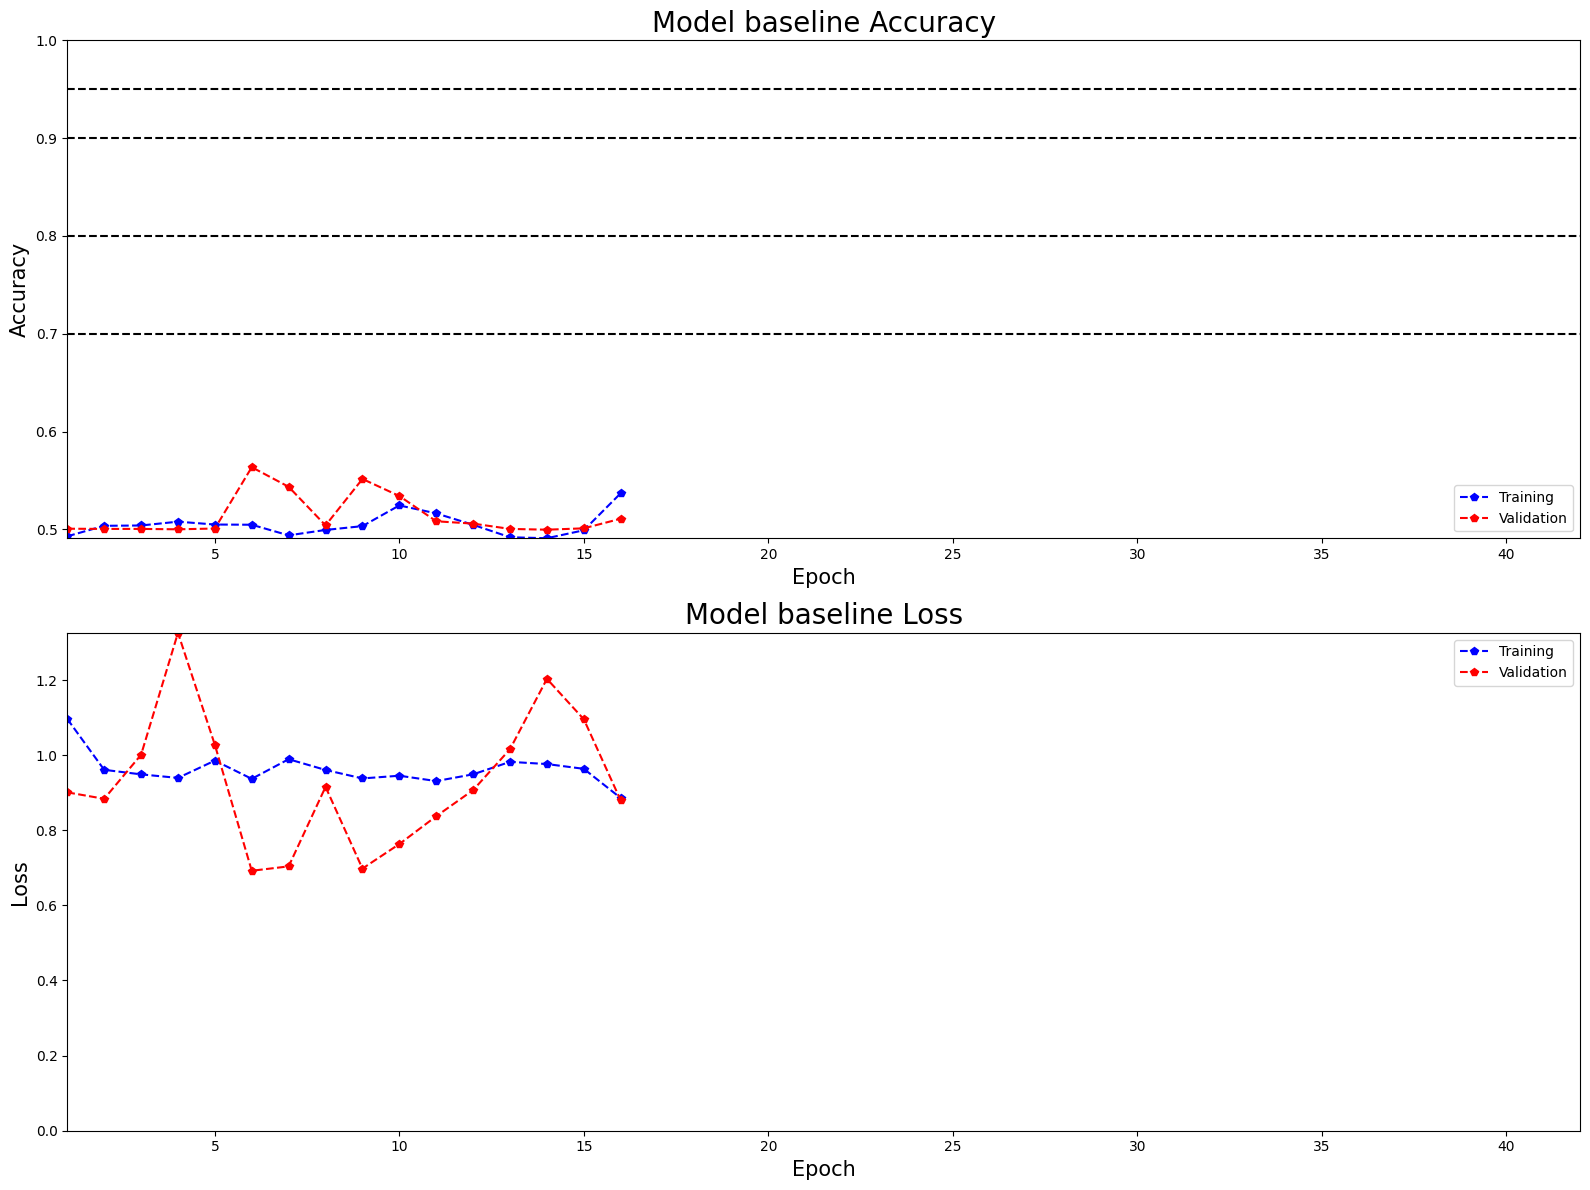

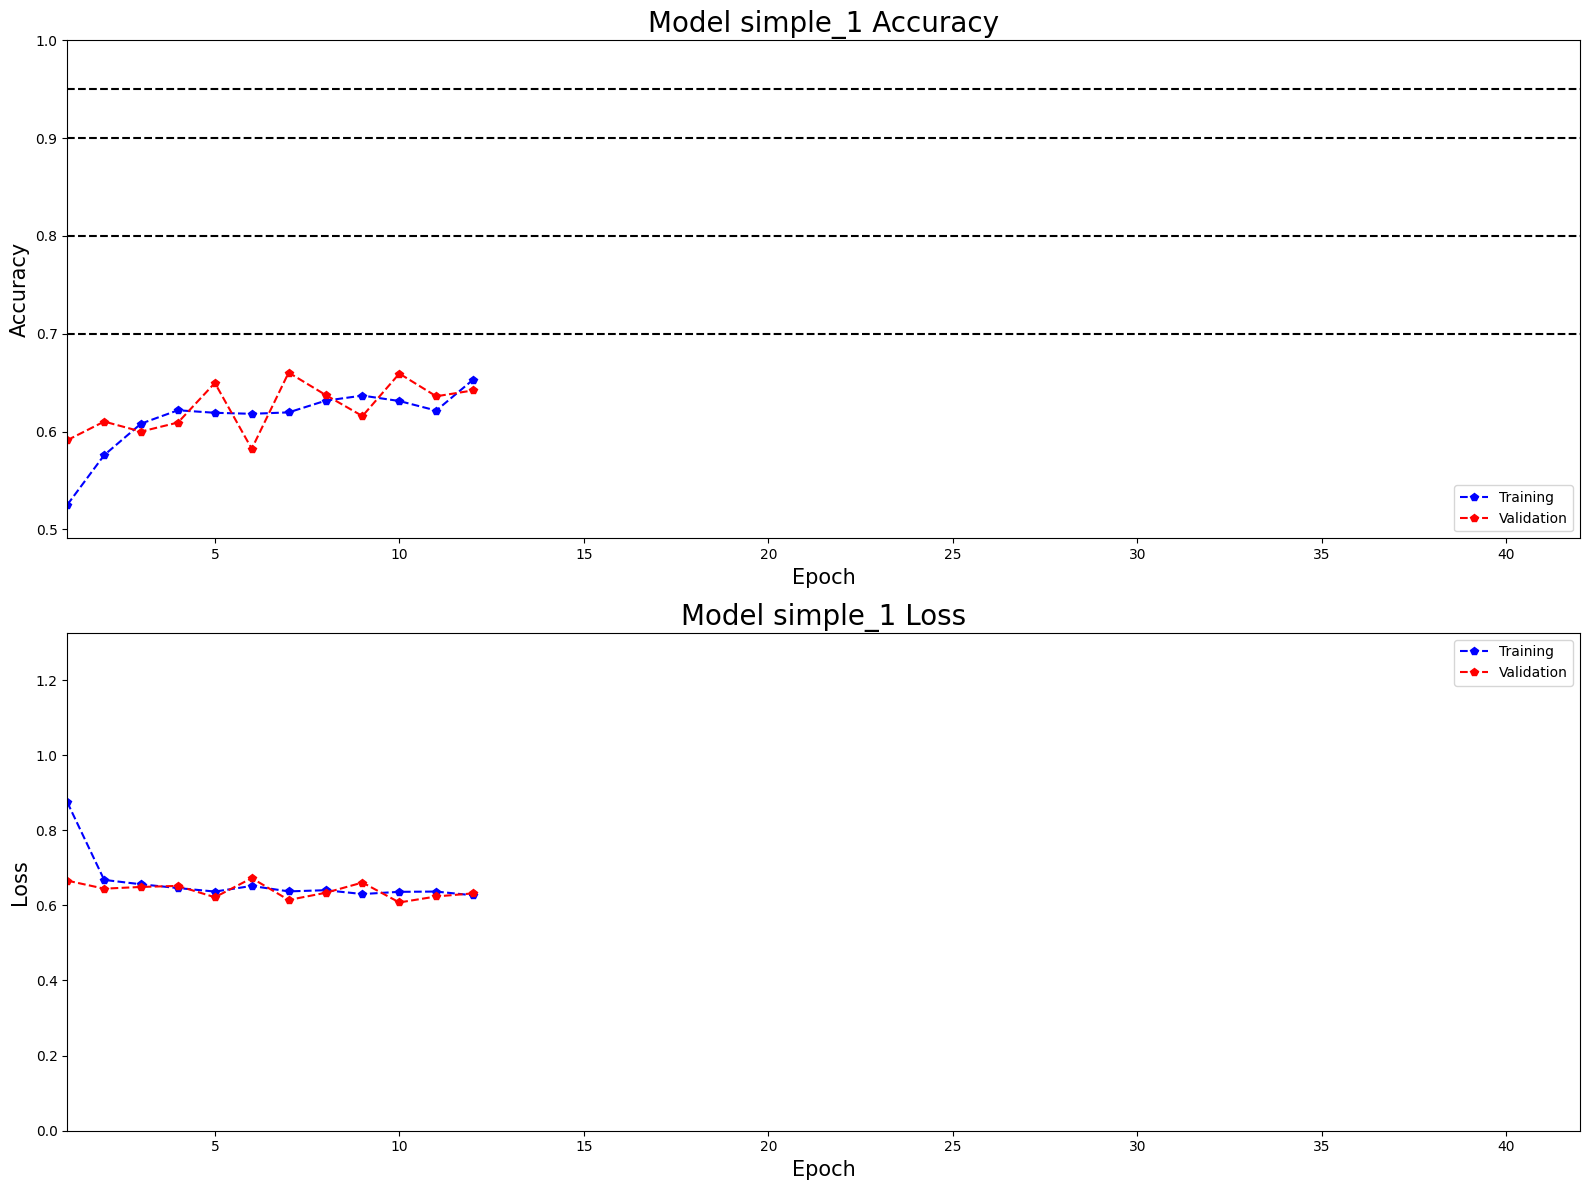

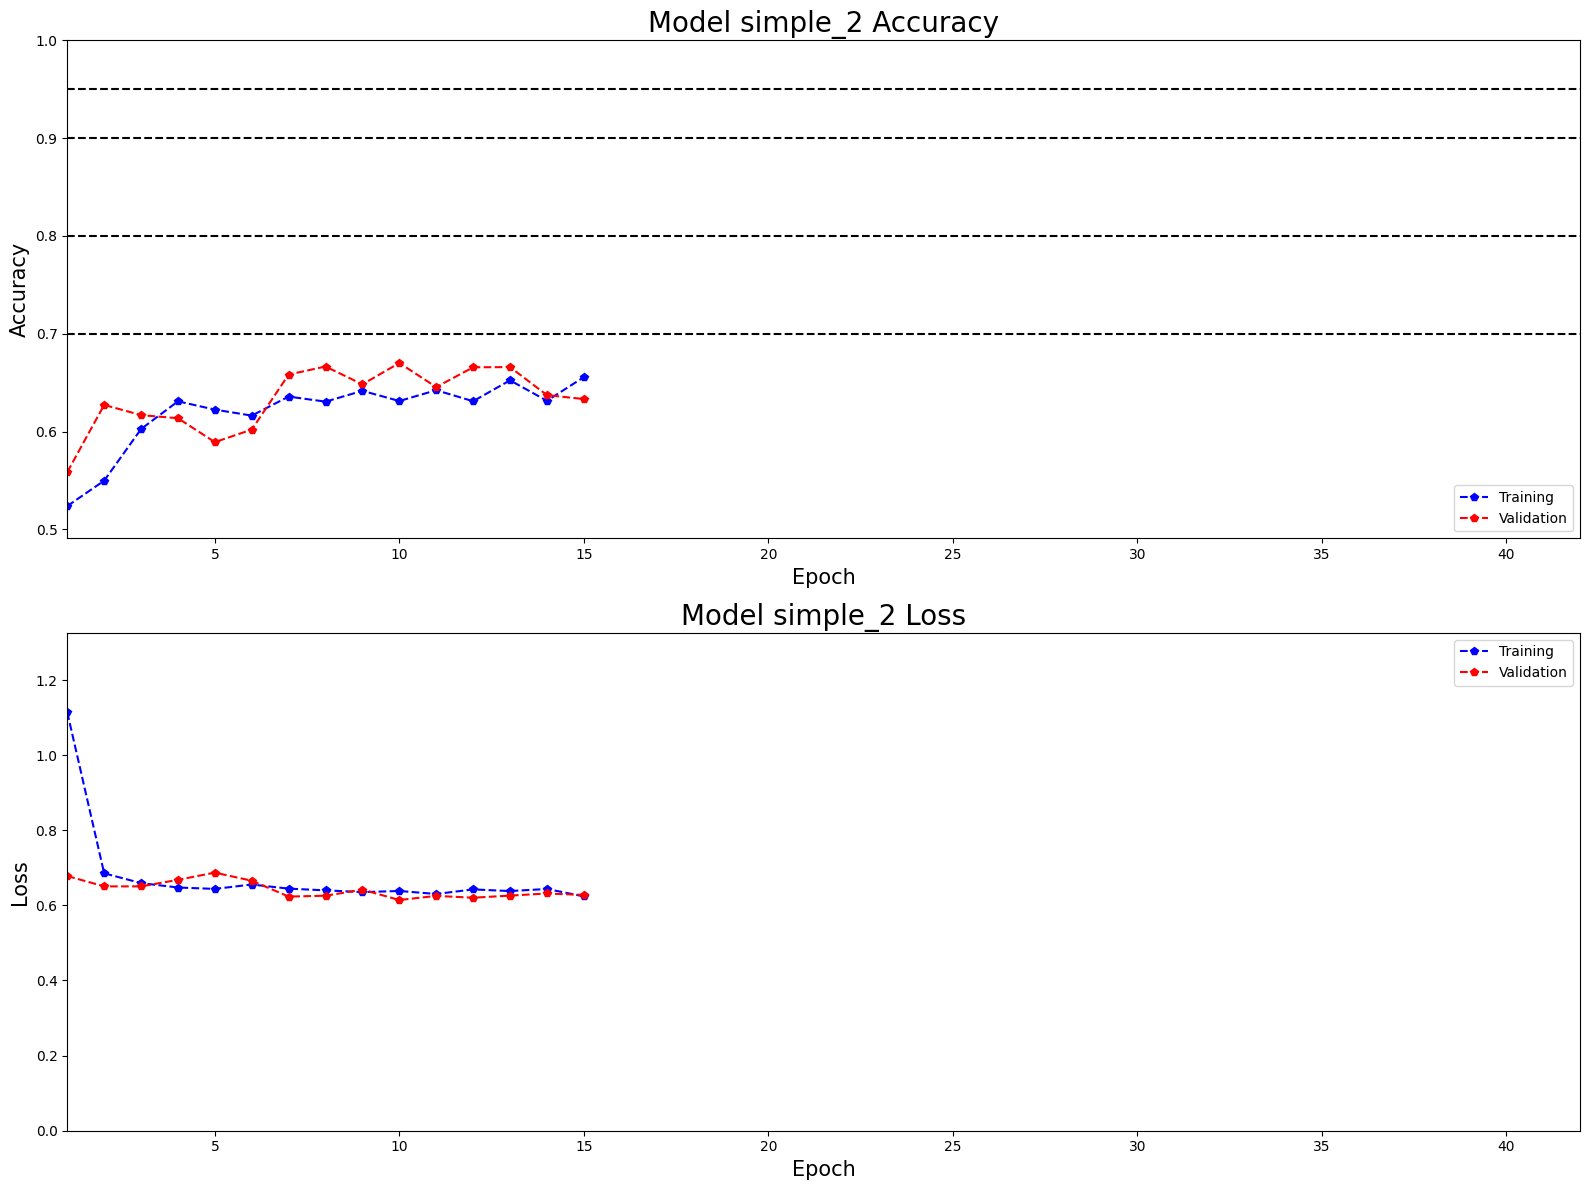

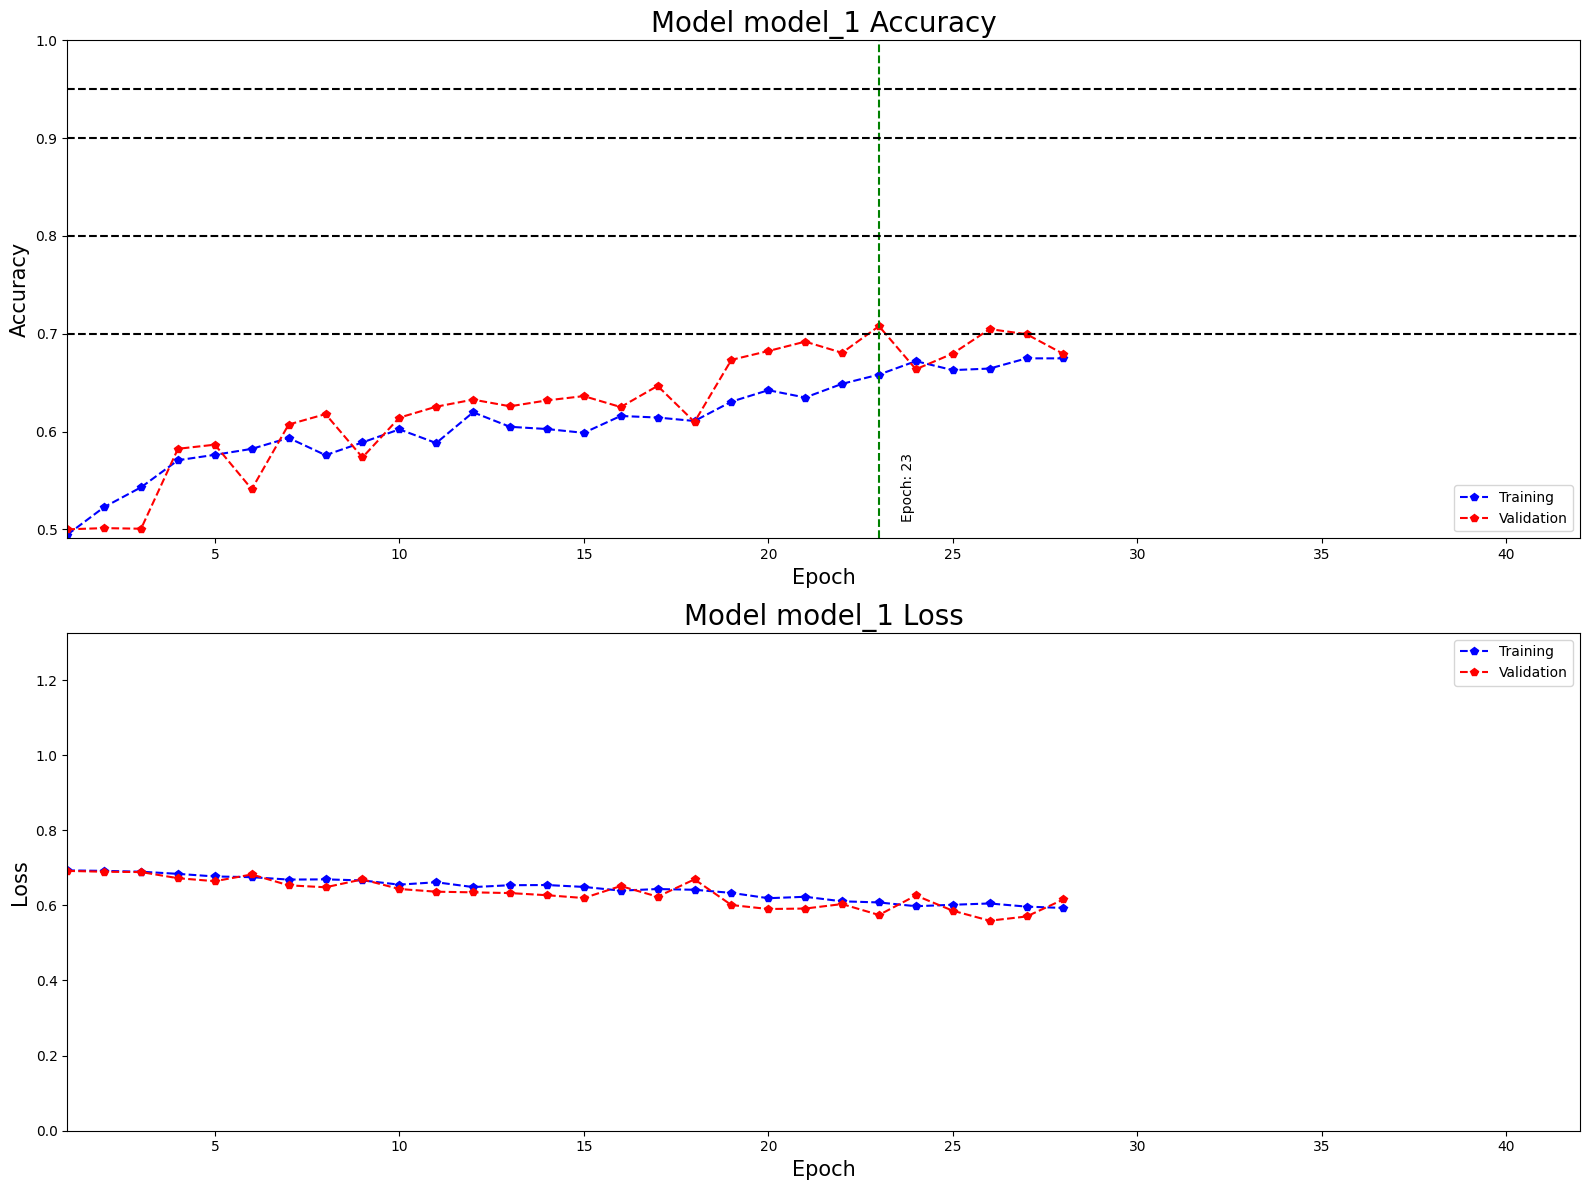

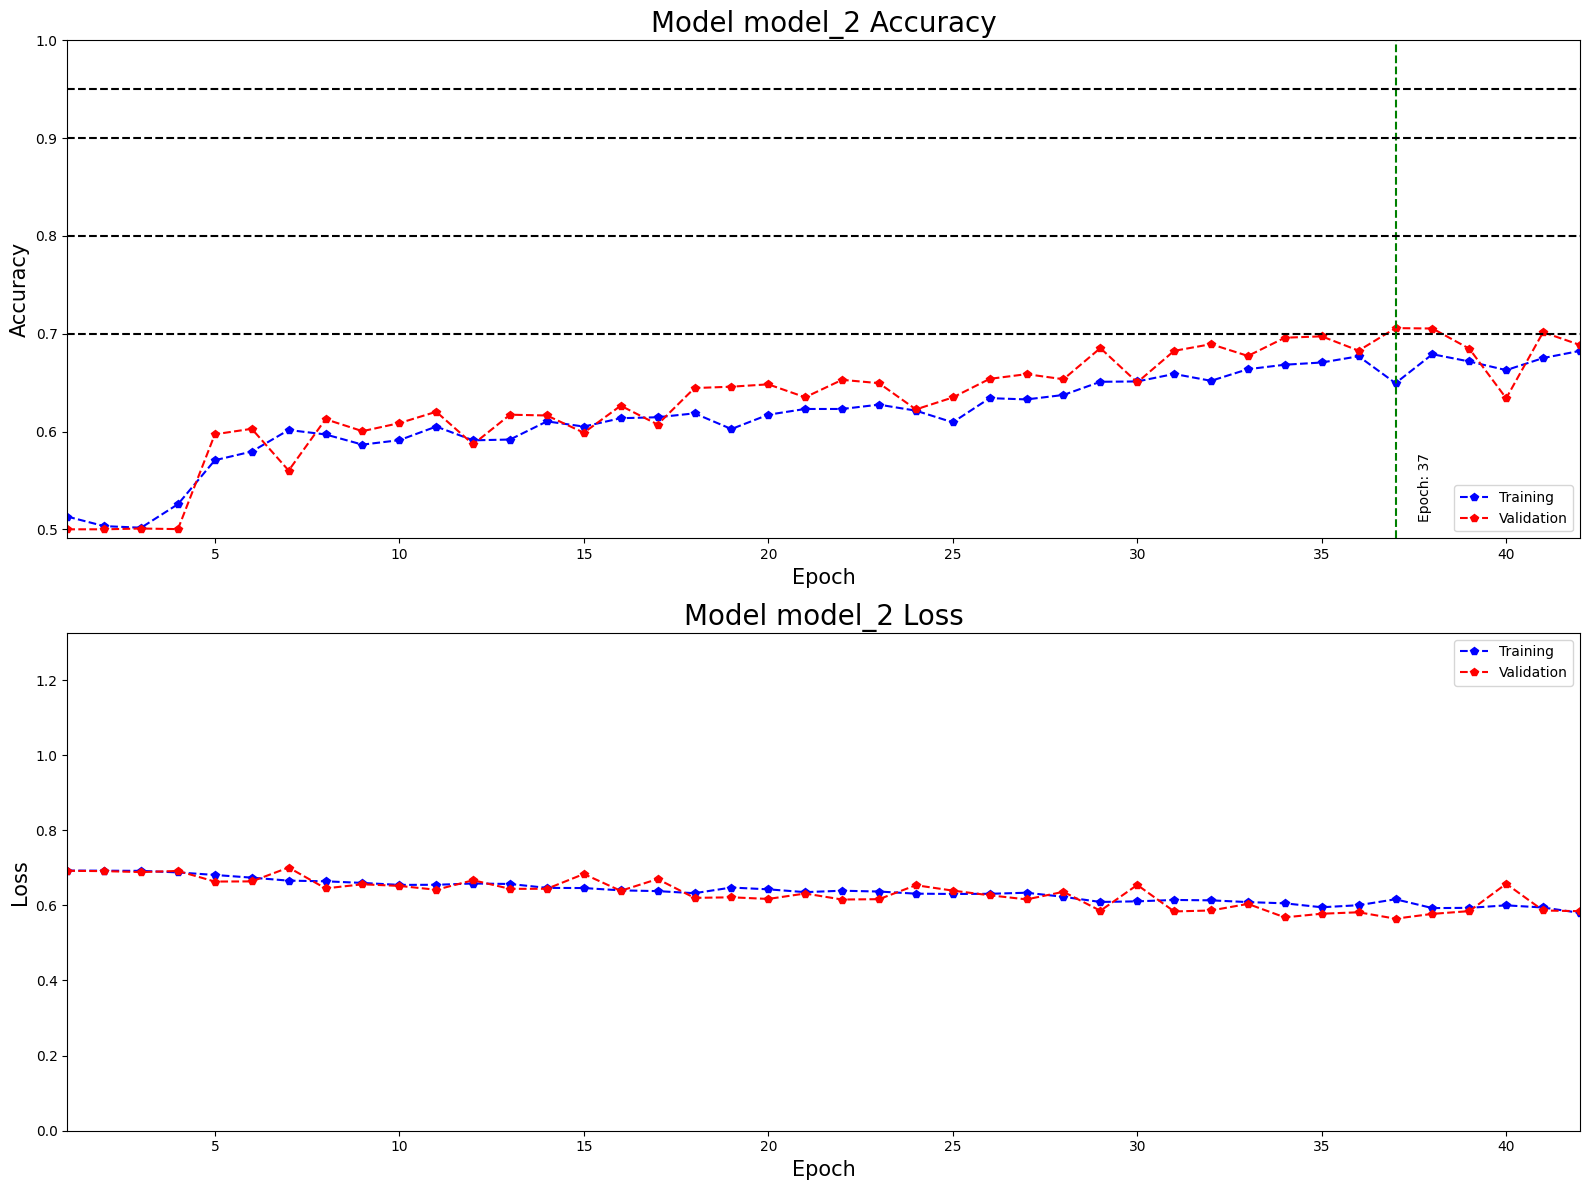

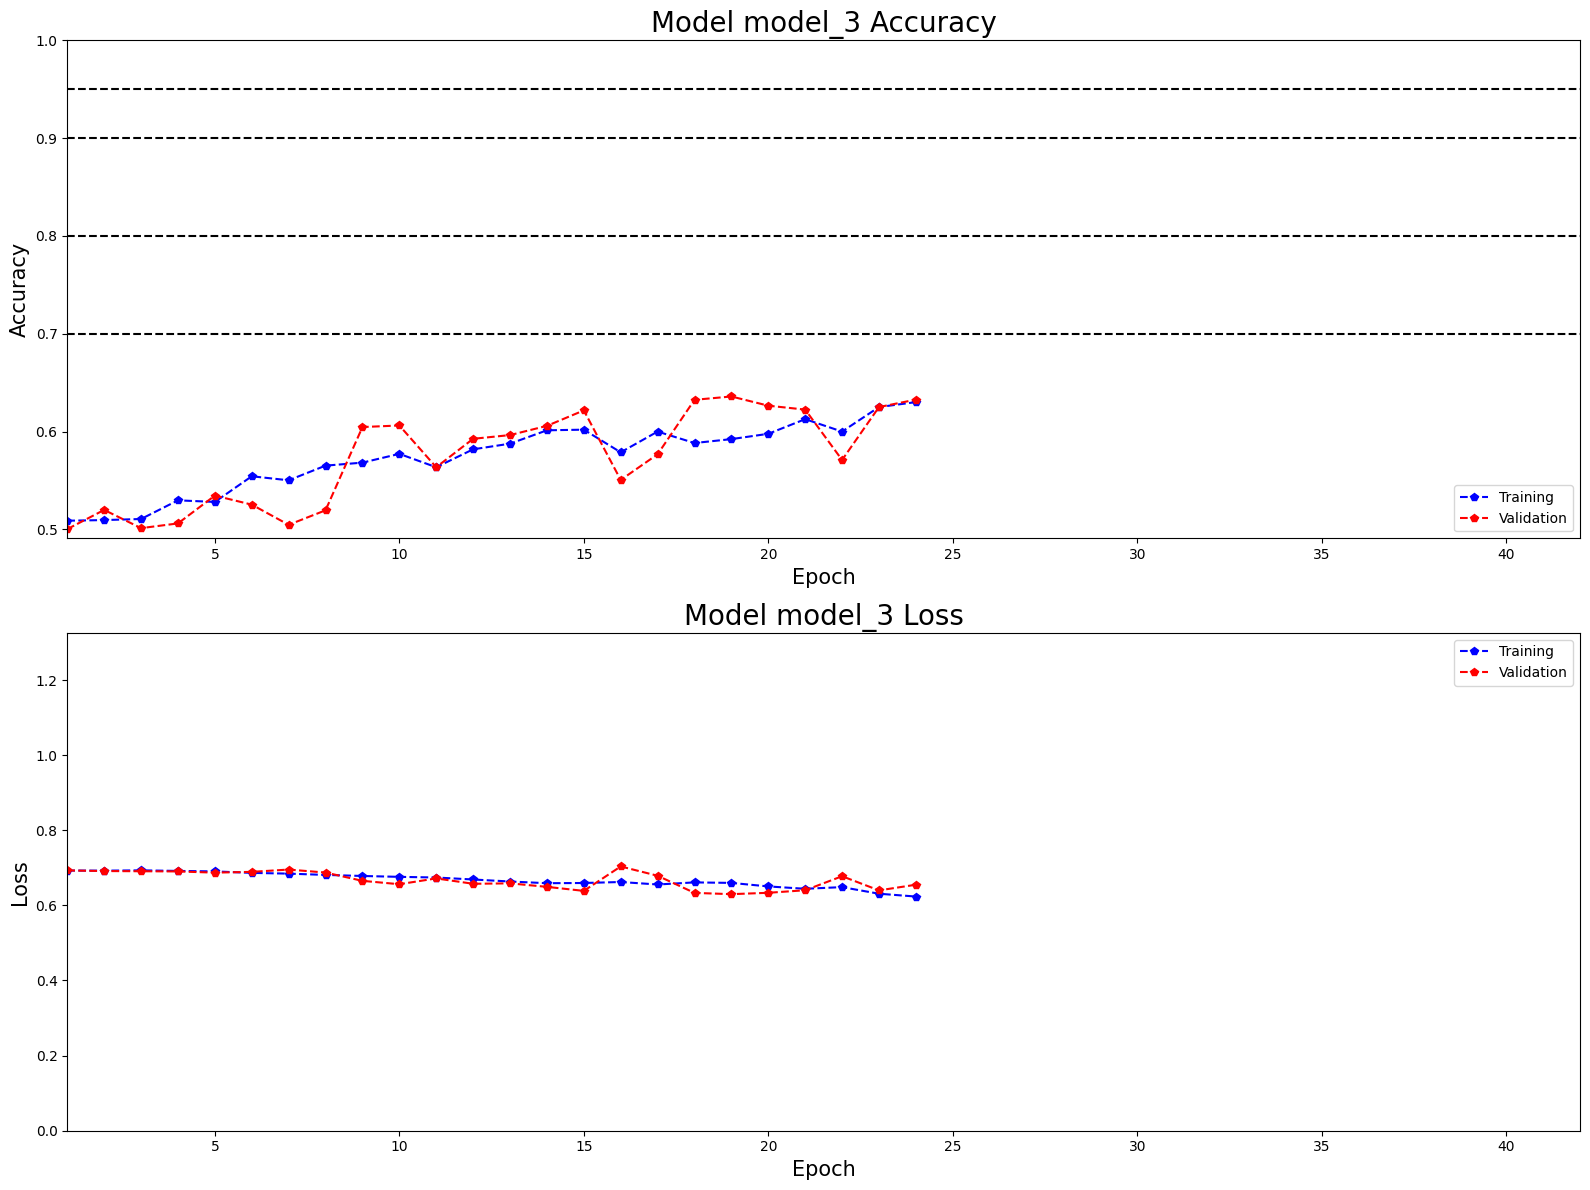

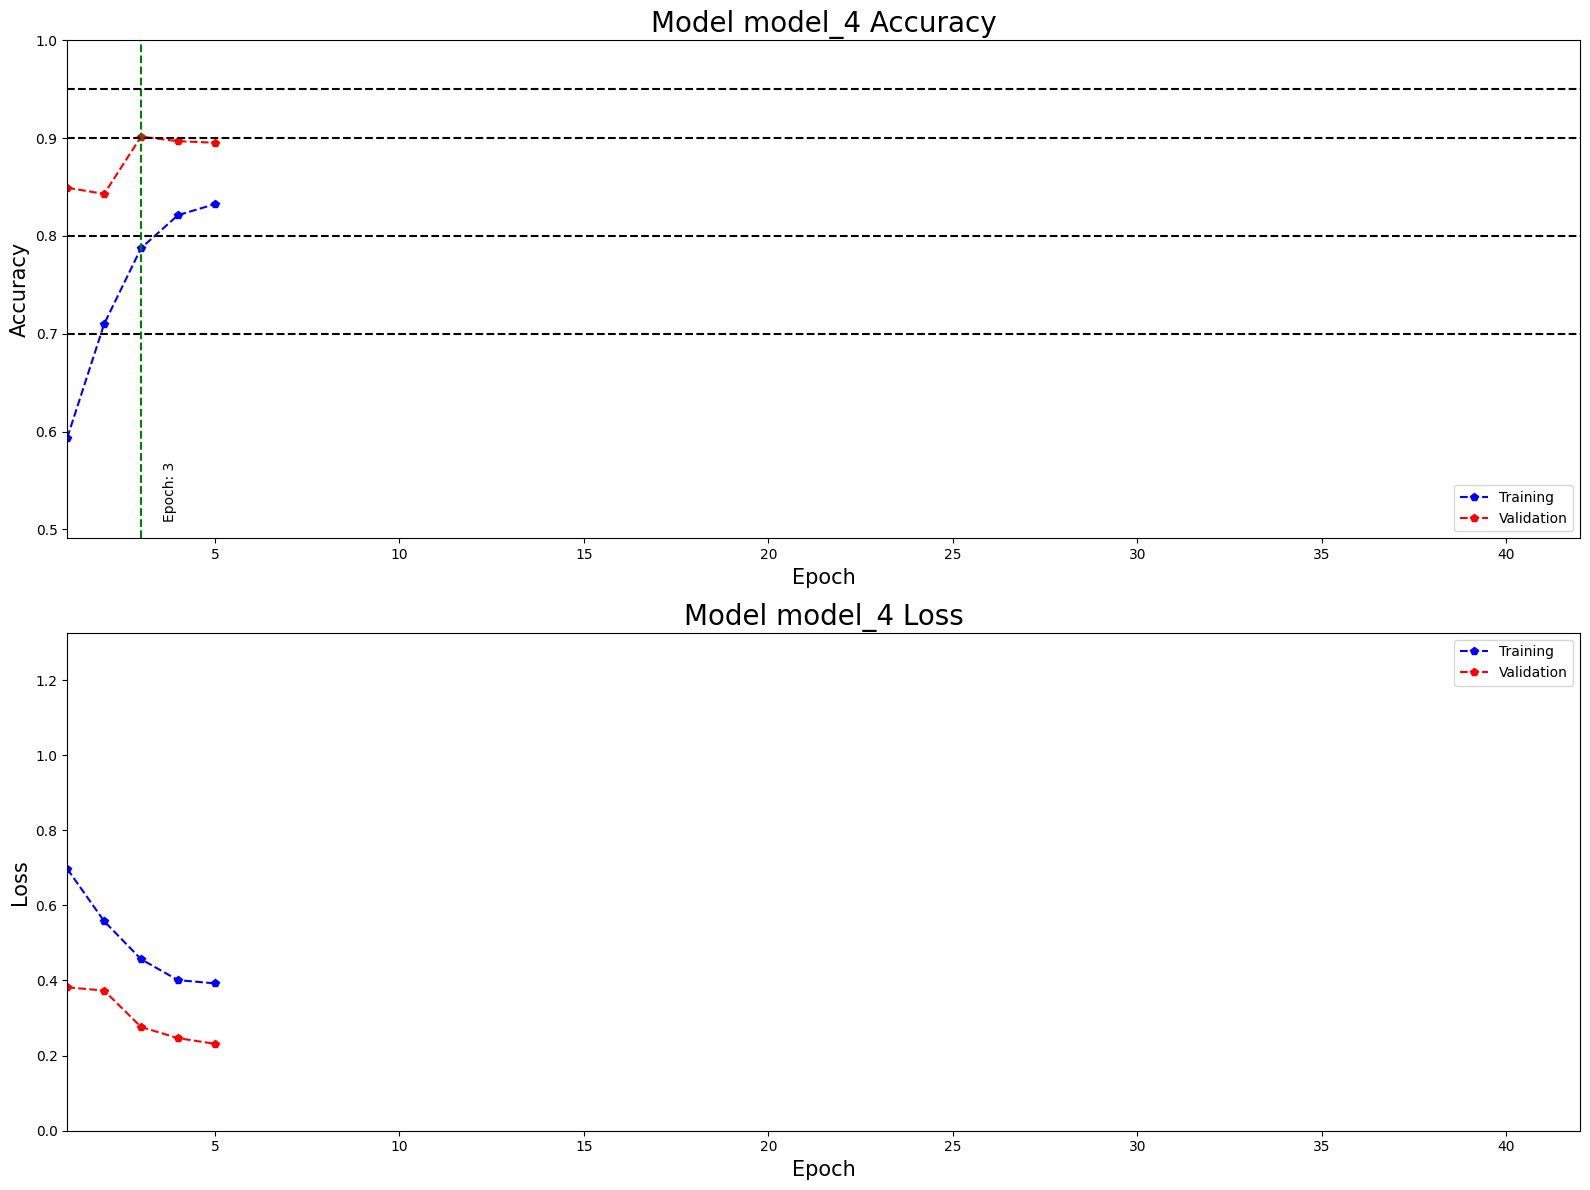

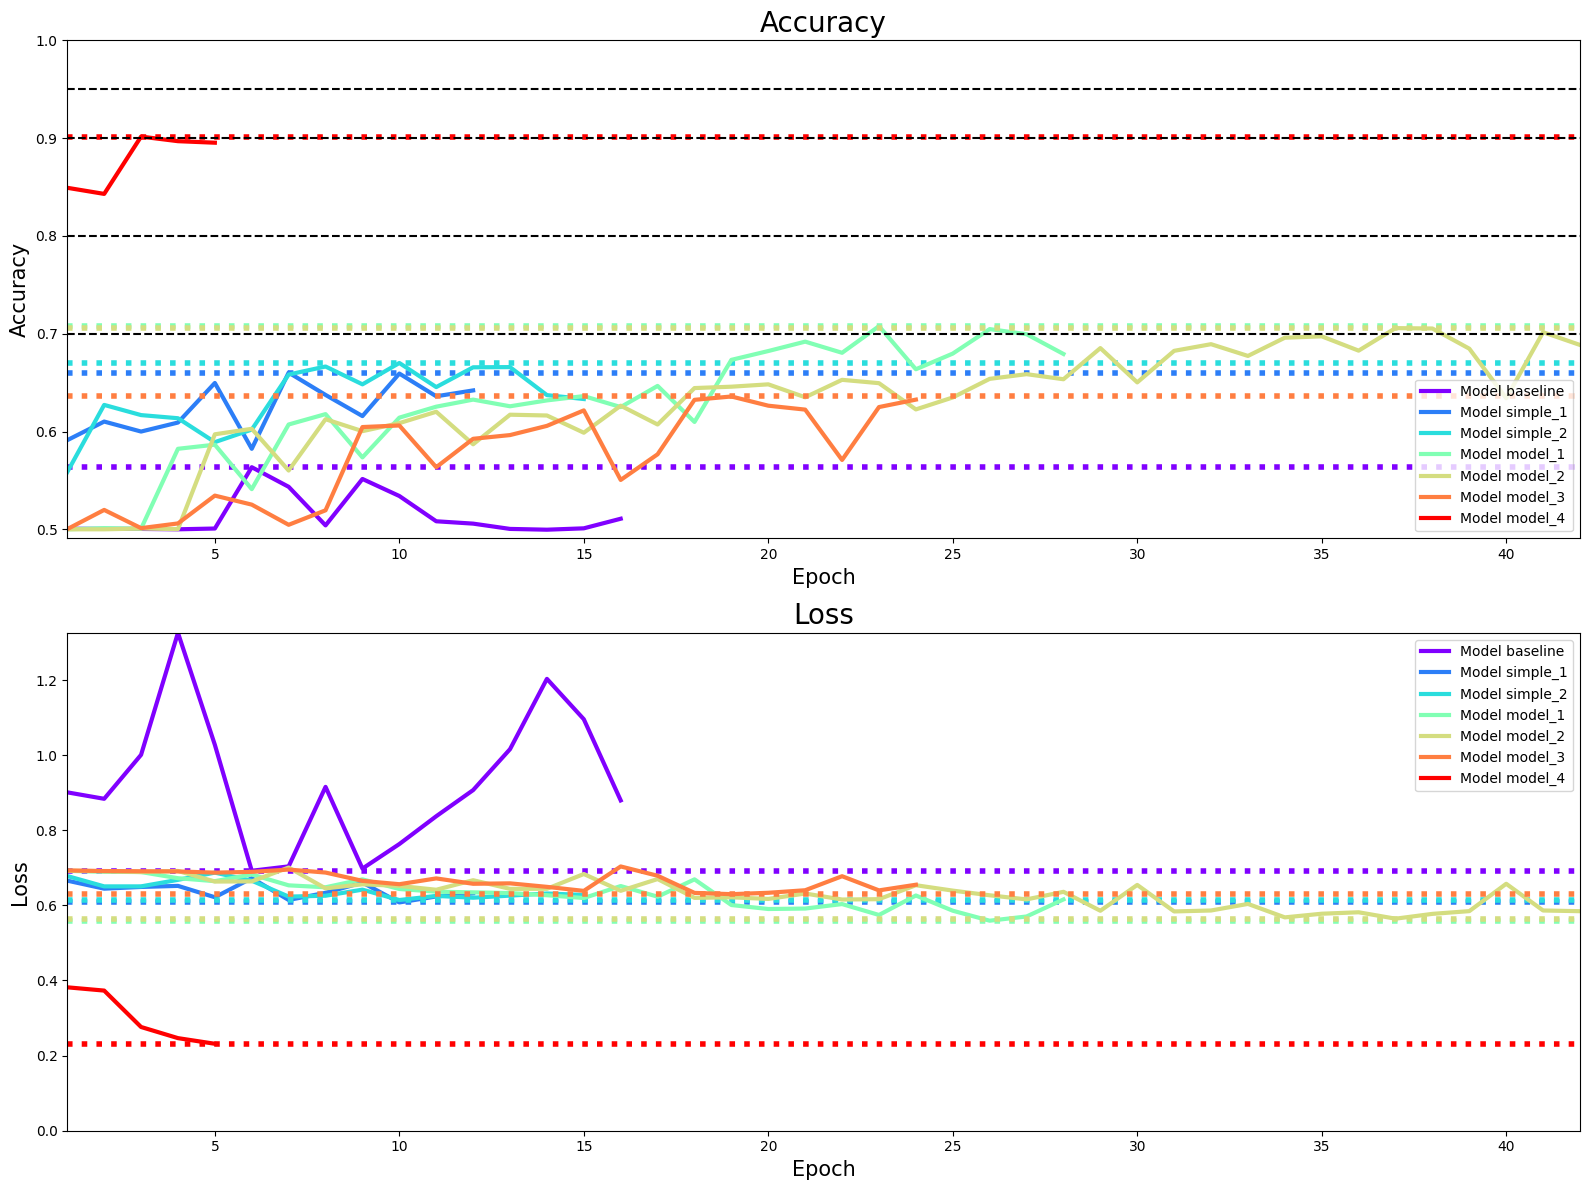

In [39]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()

In [ ]:
# Ewaluacja modeli na zbiorze testowym
model_names = [
    'baseline',
    'simple_1',
    'simple_2',
    'model_1',
    'model_2',
    'model_3',
    'model_4'
]

# Przygotowanie generatora testowego
batch_size_test = 32
img_width, img_height = 150, 150
test_data_dir = 'dataset/test/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size_test,
    class_mode='binary',
    shuffle=False
)

results = {}
for name in model_names:
    try:
        # Wczytaj model jeśli jest w pamięci, jeśli nie - pomiń
        model = globals().get(f'model_{name}') if name != 'baseline' else globals().get('model_baseline')
        if model is None:
            print(f'Model {name} nie jest załadowany w pamięci. Pomiń lub załaduj model.')
            continue
        loss, acc = model.evaluate(test_generator, verbose=0)
        results[name] = {'test_accuracy': acc, 'test_loss': loss}
        print(f"Model {name}: test_accuracy={acc:.4f}, test_loss={loss:.4f}")
    except Exception as e:
        print(f'Błąd dla modelu {name}: {e}')

# Wyświetlenie porównania
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(results.keys(), [v['test_accuracy'] for v in results.values()], color='skyblue')
plt.ylabel('Dokładność na zbiorze testowym')
plt.title('Porównanie modeli - accuracy na zbiorze testowym')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(results.keys(), [v['test_loss'] for v in results.values()], color='salmon')
plt.ylabel('Strata na zbiorze testowym')
plt.title('Porównanie modeli - loss na zbiorze testowym')
plt.show()